In [1458]:

import importlib
import data_prep as dp
import macro_utils
import pandas as pd
importlib.reload(dp)
importlib.reload(macro_utils)
print(dir(dp))  # Check if functions appear now
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import numpy as np

Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [3]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

# OPTIONAL: concat recent news with existing df for trading.

In [2]:
df_live = dp.macro_analysis('./../clean_macro_4-10-25_to_17_news.csv', 'description', 'title')

Step 1: Loading data
Available columns in CSV: ['topic', 'title', 'description', 'source', 'published_at', 'url']
Columns after loading: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Data shape after loading: (2503, 7)
Step 2: Sorting by date
Min date: 2025-04-09 00:00:00, Max date: 2025-04-17 00:00:00
Columns after sorting: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Step 3: Calculating summary sentiment
Analyzing sentiment for 2503 entries in column 'description'...


Sentiment analysis for 'description':   5%|▍         | 119/2503 [00:03<01:16, 31.02it/s]


KeyboardInterrupt: 

In [3]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv') #adjust for live/most recent df news under /data/live

In [449]:
df_live.tail()

date  summary_mean  summary_min  summary_max  summary_pos_count  \
3 2025-04-12     -0.089461    -0.957227     0.948515                 90   
4 2025-04-13     -0.086733    -0.972444     0.952317                 74   
5 2025-04-14     -0.063972    -0.972737     0.948741                239   
6 2025-04-15     -0.174286    -0.975042     0.950775                181   
7 2025-04-16     -0.254442    -0.974785     0.947952                205   

   summary_neg_count  headline_mean  headline_min  headline_max  \
3                 43      -0.008691     -0.941981      0.939109   
4                 31      -0.158017     -0.968547      0.952738   
5                123      -0.219557     -0.973235      0.940637   
6                117      -0.138407     -0.974432      0.948124   
7                169      -0.164961     -0.974998      0.955106   

   headline_pos_count  headline_neg_count  overall_mean  overall_min  \
3                 105                  28     -0.049076    -0.949604   
4                  71                  34     -0.122375    -0.970495   
5                 208                 154     -0.141765    -0.972986   
6                 195                 103     -0.156347    -0.974737   
7                 247                 127     -0.209701    -0.974891   

   overall_max  overall_pos_count  overall_neg_count  vix_target  
3     0.943812                195                 71   30.889999  
4     0.952528                145                 65   30.889999  
5     0.944689                447                277   30.889999  
6     0.949450                376                220   30.120001  
7     0.951529                452                296   32.639999

In [538]:
# Ensure 'date' columns are datetime
df['date'] = pd.to_datetime(df['date'])
df_live['date'] = pd.to_datetime(df_live['date'])

# Remove overlap: drop April 10 from df_live if it exists in df
df_live_trimmed = df_live[df_live['date'] > df['date'].max()]

# Merge the two
df = pd.concat([df, df_live_trimmed], ignore_index=True)


KeyError: 'date'

In [452]:
df = df.drop(columns=['Unnamed: 0'])

In [453]:
df.tail()

date  summary_mean  summary_min  summary_max  summary_pos_count  \
1957 2025-04-12     -0.089461    -0.957227     0.948515                 90   
1958 2025-04-13     -0.086733    -0.972444     0.952317                 74   
1959 2025-04-14     -0.063972    -0.972737     0.948741                239   
1960 2025-04-15     -0.174286    -0.975042     0.950775                181   
1961 2025-04-16     -0.254442    -0.974785     0.947952                205   

      summary_neg_count  headline_mean  headline_min  headline_max  \
1957                 43      -0.008691     -0.941981      0.939109   
1958                 31      -0.158017     -0.968547      0.952738   
1959                123      -0.219557     -0.973235      0.940637   
1960                117      -0.138407     -0.974432      0.948124   
1961                169      -0.164961     -0.974998      0.955106   

      headline_pos_count  headline_neg_count  overall_mean  overall_min  \
1957                 105                  28     -0.049076    -0.949604   
1958                  71                  34     -0.122375    -0.970495   
1959                 208                 154     -0.141765    -0.972986   
1960                 195                 103     -0.156347    -0.974737   
1961                 247                 127     -0.209701    -0.974891   

      overall_max  overall_pos_count  overall_neg_count  vix_target  
1957     0.943812                195                 71   30.889999  
1958     0.952528                145                 65   30.889999  
1959     0.944689                447                277   30.889999  
1960     0.949450                376                220   30.120001  
1961     0.951529                452                296   32.639999

In [1237]:
df = pd.read_csv('./../data/live/7y_up_to_4_17_2025_news.csv')
df = macro_utils.calculate_stats(df)

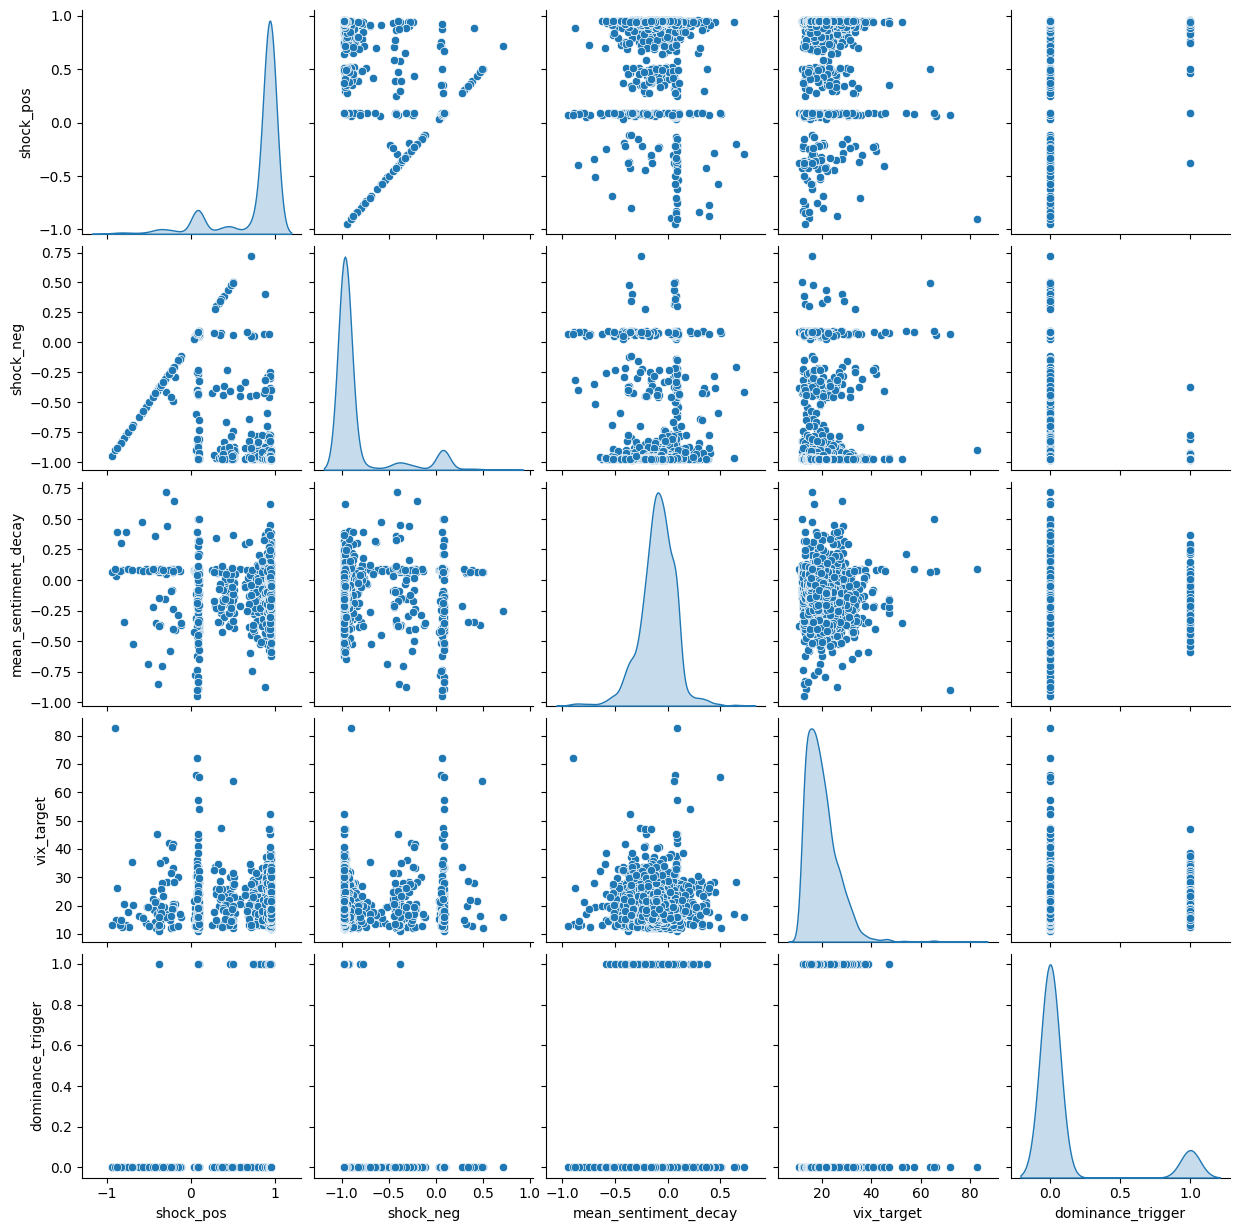

In [1238]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target', 'dominance_trigger'], diag_kind='kde')


In [1239]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]
selected_features = feature_sets[0]

In [1240]:
df.index = pd.to_datetime(df['date'])
df.tail()

date      date.1  summary_mean  summary_min  summary_max  \
date                                                                         
2025-04-12  2025-04-12  2025-04-12     -0.089461    -0.957227     0.948515   
2025-04-13  2025-04-13  2025-04-13     -0.086733    -0.972444     0.952317   
2025-04-14  2025-04-14  2025-04-14     -0.063972    -0.972737     0.948741   
2025-04-15  2025-04-15  2025-04-15     -0.174286    -0.975042     0.950775   
2025-04-16  2025-04-16  2025-04-16     -0.254442    -0.974785     0.947952   

            summary_pos_count  summary_neg_count  headline_mean  headline_min  \
date                                                                            
2025-04-12                 90                 43      -0.008691     -0.941981   
2025-04-13                 74                 31      -0.158017     -0.968547   
2025-04-14                239                123      -0.219557     -0.973235   
2025-04-15                181                117      -0.138407     -0.974432   
2025-04-16                205                169      -0.164961     -0.974998   

            headline_max  ...  mean_sentiment_decay  shock_pos  shock_neg  \
date                      ...                                               
2025-04-12      0.939109  ...             -0.304711   0.943812  -0.949604   
2025-04-13      0.952738  ...             -0.049076   0.952528  -0.970495   
2025-04-14      0.940637  ...             -0.122375   0.944689  -0.972986   
2025-04-15      0.948124  ...             -0.141765   0.949450  -0.974737   
2025-04-16      0.955106  ...             -0.156347   0.951529  -0.974891   

            sentiment_dominance  dominance_trigger  vix_7d_pct  vix_zscore  \
date                                                                         
2025-04-12                   47                  0    0.426790    0.340215   
2025-04-13                   43                  0    0.386445    0.313508   
2025-04-14                  116                  0    0.386445    0.283756   
2025-04-15                   64                  0    0.351885    0.185777   
2025-04-16                   36                  0    0.499311    0.382230   

             ewm_mean    ewm_std  vix_ewm_zscore  
date                                              
2025-04-12  30.907810  11.605613       -0.001535  
2025-04-13  30.906581  11.198272       -0.001481  
2025-04-14  30.905438  10.805228       -0.001429  
2025-04-15  30.851270  10.427948       -0.070126  
2025-04-16  30.974630  10.072522        0.165338  

[5 rows x 28 columns]

In [1241]:
df = df.drop(columns=['date', 'date.1'])

In [1242]:
df = df.drop(columns=['summary_max', 'summary_pos_count', 'headline_max', 'overall_max', 'shock_pos'])

In [1243]:
#df['vix_target_log'] = np.log(df['vix_target'])
#df['vix_target_log_ret'] = df['vix_target_log'].diff().dropna()

# Train: Post-COVID to end of 2023
train_df = df[(df.index >= "2021-05-01") & (df.index <= "2024-10-15")]
# Test: Recent years
test_df = df[df.index >= "2024-10-16"]
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[0] + ['vix_zscore']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_ewm_zscore']


Train set: 1253 rows
Test set: 183 rows


In [1244]:
train_df.tail()

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2024-10-11     -0.313376    -0.972448                 58      -0.157393   
2024-10-12      0.181630    -0.959148                  9       0.054226   
2024-10-13     -0.280690    -0.969393                 10      -0.232838   
2024-10-14      0.009047    -0.974299                 24      -0.044218   
2024-10-15     -0.242439    -0.975493                 63      -0.210137   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2024-10-11     -0.971905                  57                  48   
2024-10-12     -0.946041                  31                   6   
2024-10-13     -0.916358                  12                   8   
2024-10-14     -0.972195                  43                  20   
2024-10-15     -0.972273                  74                  56   

            overall_mean  overall_min  overall_pos_count  ...  vix_target  \
date                                                      ...               
2024-10-11     -0.235385    -0.972176                104  ...   20.459999   
2024-10-12      0.117928    -0.952595                 59  ...   19.700001   
2024-10-13     -0.256764    -0.942875                 22  ...   19.700001   
2024-10-14     -0.017585    -0.973247                 82  ...   19.700001   
2024-10-15     -0.226288    -0.973883                141  ...   20.639999   

            mean_sentiment_decay  shock_neg  sentiment_dominance  \
date                                                               
2024-10-11             -0.085379  -0.972176                  -11   
2024-10-12             -0.235385  -0.952595                   19   
2024-10-13              0.117928  -0.942875                    0   
2024-10-14             -0.256764  -0.973247                   15   
2024-10-15             -0.017585  -0.973883                    4   

            dominance_trigger  vix_7d_pct  vix_zscore   ewm_mean   ewm_std  \
date                                                                         
2024-10-11                  1    0.331165    0.993342  19.186137  2.634178   
2024-10-12                  0    0.161557    0.630209  19.221576  2.545179   
2024-10-13                  0    0.177525    0.587371  19.254571  2.458947   
2024-10-14                  0    0.177525    0.550558  19.285290  2.375424   
2024-10-15                  0    0.233712    0.892232  19.378718  2.318554   

            vix_ewm_zscore  
date                        
2024-10-11        0.483590  
2024-10-12        0.187973  
2024-10-13        0.181147  
2024-10-14        0.174584  
2024-10-15        0.543995  

[5 rows x 21 columns]

In [1245]:
test_df_trade = test_df.copy()

In [1246]:
test_df.tail()

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2025-04-12     -0.089461    -0.957227                 43      -0.008691   
2025-04-13     -0.086733    -0.972444                 31      -0.158017   
2025-04-14     -0.063972    -0.972737                123      -0.219557   
2025-04-15     -0.174286    -0.975042                117      -0.138407   
2025-04-16     -0.254442    -0.974785                169      -0.164961   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2025-04-12     -0.941981                 105                  28   
2025-04-13     -0.968547                  71                  34   
2025-04-14     -0.973235                 208                 154   
2025-04-15     -0.974432                 195                 103   
2025-04-16     -0.974998                 247                 127   

            overall_mean  overall_min  overall_pos_count  ...  vix_target  \
date                                                      ...               
2025-04-12     -0.049076    -0.949604                195  ...   30.889999   
2025-04-13     -0.122375    -0.970495                145  ...   30.889999   
2025-04-14     -0.141765    -0.972986                447  ...   30.889999   
2025-04-15     -0.156347    -0.974737                376  ...   30.120001   
2025-04-16     -0.209701    -0.974891                452  ...   32.639999   

            mean_sentiment_decay  shock_neg  sentiment_dominance  \
date                                                               
2025-04-12             -0.304711  -0.949604                   47   
2025-04-13             -0.049076  -0.970495                   43   
2025-04-14             -0.122375  -0.972986                  116   
2025-04-15             -0.141765  -0.974737                   64   
2025-04-16             -0.156347  -0.974891                   36   

            dominance_trigger  vix_7d_pct  vix_zscore   ewm_mean    ewm_std  \
date                                                                          
2025-04-12                  0    0.426790    0.340215  30.907810  11.605613   
2025-04-13                  0    0.386445    0.313508  30.906581  11.198272   
2025-04-14                  0    0.386445    0.283756  30.905438  10.805228   
2025-04-15                  0    0.351885    0.185777  30.851270  10.427948   
2025-04-16                  0    0.499311    0.382230  30.974630  10.072522   

            vix_ewm_zscore  
date                        
2025-04-12       -0.001535  
2025-04-13       -0.001481  
2025-04-14       -0.001429  
2025-04-15       -0.070126  
2025-04-16        0.165338  

[5 rows x 21 columns]

In [1247]:
transition_matrix, results, df_model = macro_utils.regime_t_markov_model(X, y, df_model)

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


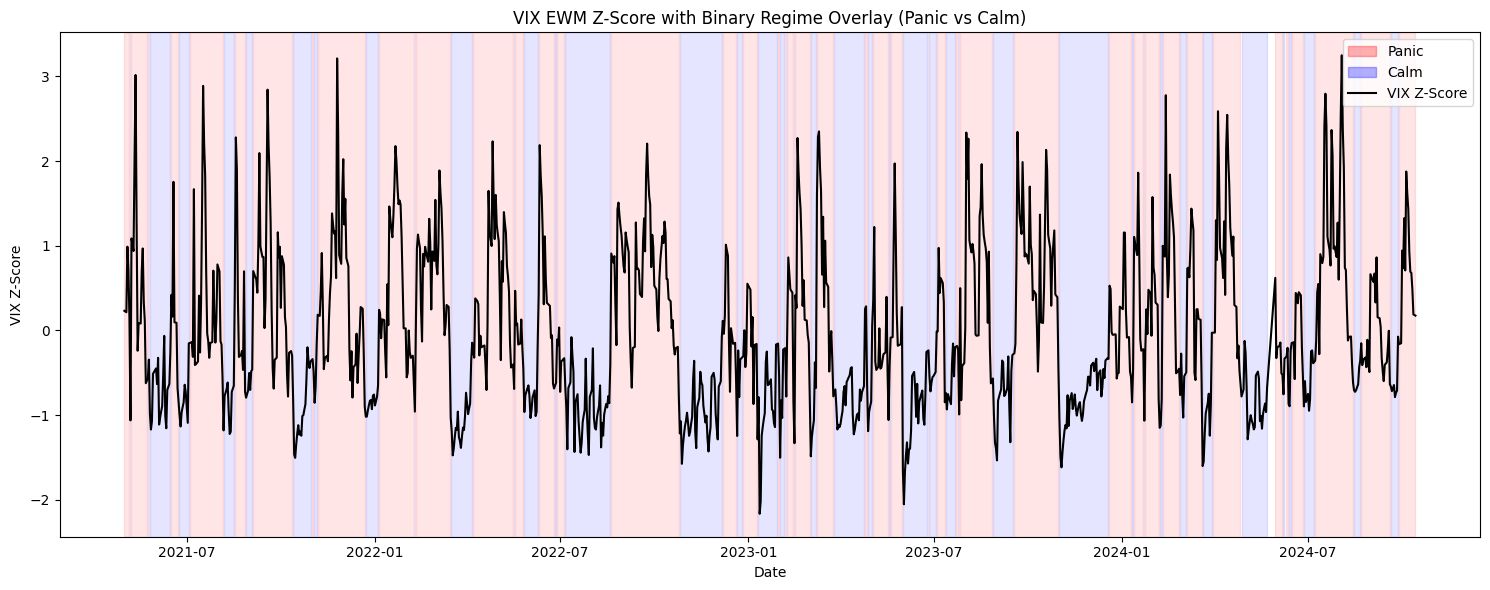

In [1303]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_ewm_zscore'], label='VIX_t (EWM Z-Score)', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.1)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.1)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX EWM Z-Score with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


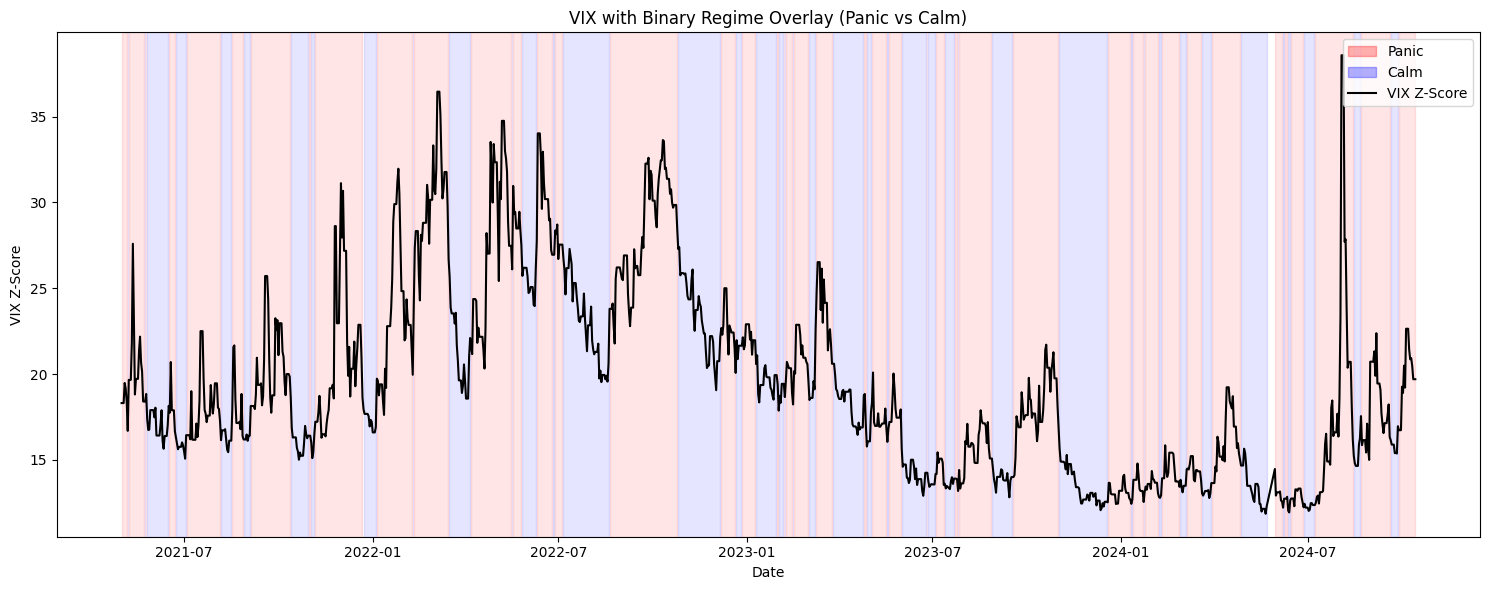

In [1304]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_target'], label='VIX_t', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.1)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.1)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


In [1305]:
df_model.tail()

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2024-10-10     -0.008239    -0.976220                 42      -0.162519   
2024-10-11     -0.313376    -0.972448                 58      -0.157393   
2024-10-12      0.181630    -0.959148                  9       0.054226   
2024-10-13     -0.280690    -0.969393                 10      -0.232838   
2024-10-14      0.009047    -0.974299                 24      -0.044218   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2024-10-10     -0.972208                  66                  47   
2024-10-11     -0.971905                  57                  48   
2024-10-12     -0.946041                  31                   6   
2024-10-13     -0.916358                  12                   8   
2024-10-14     -0.972195                  43                  20   

            overall_mean  overall_min  overall_pos_count  ...  regime_1_prob  \
date                                                      ...                  
2024-10-10     -0.085379    -0.974214                137  ...       0.098818   
2024-10-11     -0.235385    -0.972176                104  ...       0.551793   
2024-10-12      0.117928    -0.952595                 59  ...       0.939235   
2024-10-13     -0.256764    -0.942875                 22  ...       0.983608   
2024-10-14     -0.017585    -0.973247                 82  ...       0.986780   

            regime_2_prob  regime_t+1  regime_t+1_raw  panic_prob  \
date                                                                
2024-10-10       0.901161         1.0             1.0    0.702603   
2024-10-11       0.447773         1.0             1.0    0.890815   
2024-10-12       0.056178         1.0             1.0    0.707810   
2024-10-13       0.010567         1.0             1.0    0.610102   
2024-10-14       0.007100         1.0             1.0    0.526360   

            regime_group  is_sustained_regime1  regime_t-1  is_transition  \
date                                                                        
2024-10-10            85                  True         1.0          False   
2024-10-11            85                  True         1.0          False   
2024-10-12            85                  True         1.0          False   
2024-10-13            85                  True         1.0          False   
2024-10-14            85                  True         1.0          False   

            vix_target_t+1  
date                        
2024-10-10       20.459999  
2024-10-11       19.700001  
2024-10-12       19.700001  
2024-10-13       19.700001  
2024-10-14             NaN  

[5 rows x 34 columns]

In [1306]:
clf, y_pred, classification_df = macro_utils.clf_panic_tomorrow(df_model, selected_features, 'regime_t+1')

              precision    recall  f1-score   support

         0.0       0.86      0.24      0.38       479
         1.0       0.68      0.98      0.80       773

    accuracy                           0.69      1252
   macro avg       0.77      0.61      0.59      1252
weighted avg       0.75      0.69      0.64      1252



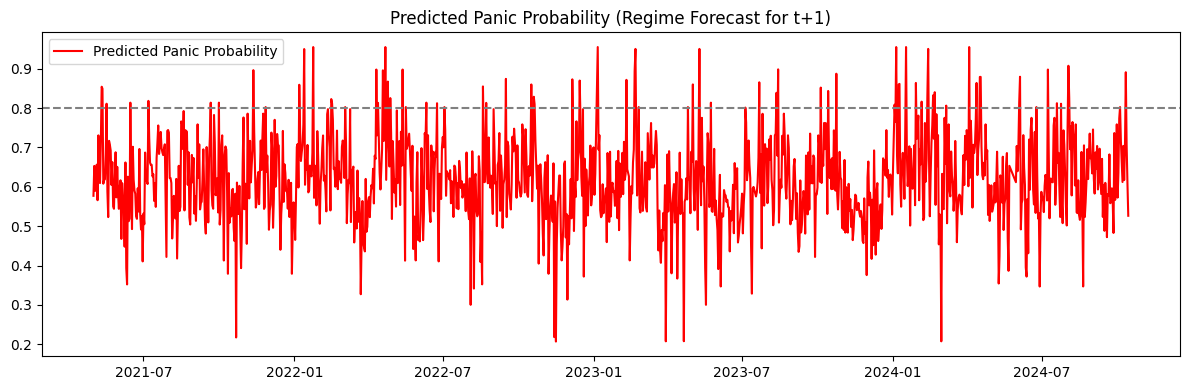

In [1307]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.8, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


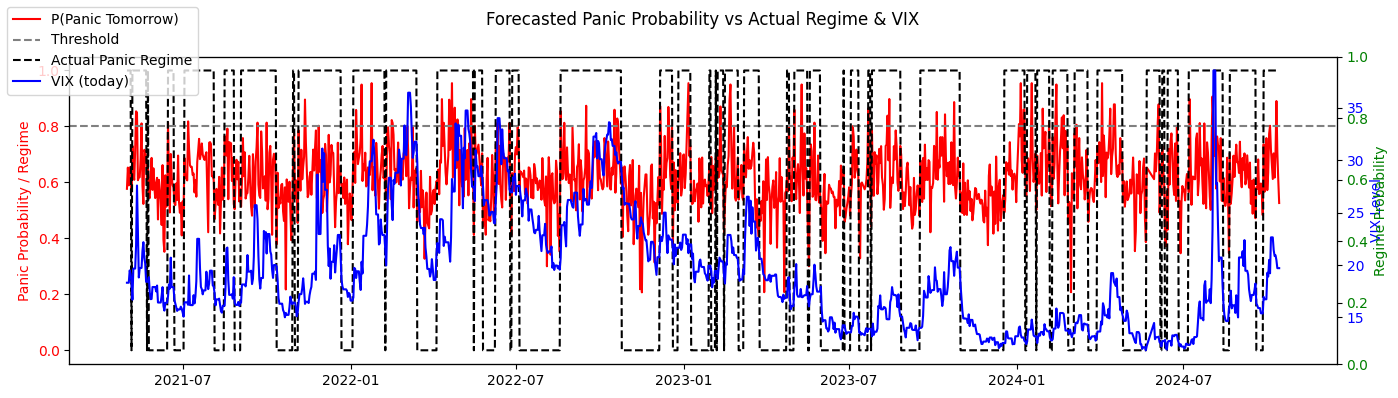

In [1308]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.8, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [1395]:

# Train dataset (classification_df)
classification_df = macro_utils.identify_sustained_regimes_and_transitions(classification_df)

# Now you can apply it to the test data (test_df) in the same way:




In [1396]:
classification_df.tail()

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2024-10-10     -0.008239    -0.976220                 42      -0.162519   
2024-10-11     -0.313376    -0.972448                 58      -0.157393   
2024-10-12      0.181630    -0.959148                  9       0.054226   
2024-10-13     -0.280690    -0.969393                 10      -0.232838   
2024-10-14      0.009047    -0.974299                 24      -0.044218   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2024-10-10     -0.972208                  66                  47   
2024-10-11     -0.971905                  57                  48   
2024-10-12     -0.946041                  31                   6   
2024-10-13     -0.916358                  12                   8   
2024-10-14     -0.972195                  43                  20   

            overall_mean  overall_min  overall_pos_count  ...  regime_1_prob  \
date                                                      ...                  
2024-10-10     -0.085379    -0.974214                137  ...       0.098818   
2024-10-11     -0.235385    -0.972176                104  ...       0.551793   
2024-10-12      0.117928    -0.952595                 59  ...       0.939235   
2024-10-13     -0.256764    -0.942875                 22  ...       0.983608   
2024-10-14     -0.017585    -0.973247                 82  ...       0.986780   

            regime_2_prob  regime_t+1  regime_t+1_raw  panic_prob  \
date                                                                
2024-10-10       0.901161         1.0             1.0    0.702603   
2024-10-11       0.447773         1.0             1.0    0.890815   
2024-10-12       0.056178         1.0             1.0    0.707810   
2024-10-13       0.010567         1.0             1.0    0.610102   
2024-10-14       0.007100         1.0             1.0    0.526360   

            regime_group  is_sustained_regime1  regime_t-1  is_transition  \
date                                                                        
2024-10-10            85                  True         1.0          False   
2024-10-11            85                  True         1.0          False   
2024-10-12            85                  True         1.0          False   
2024-10-13            85                  True         1.0          False   
2024-10-14            85                  True         1.0          False   

            vix_target_t+1  
date                        
2024-10-10       20.459999  
2024-10-11       19.700001  
2024-10-12       19.700001  
2024-10-13       19.700001  
2024-10-14             NaN  

[5 rows x 34 columns]

In [1406]:

# Usage Example:
result = macro_utils.transform_vix_data(classification_df, window=60)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


In [1407]:

regime_windows_df_train = regime_windows_df_train.replace(2, 1)


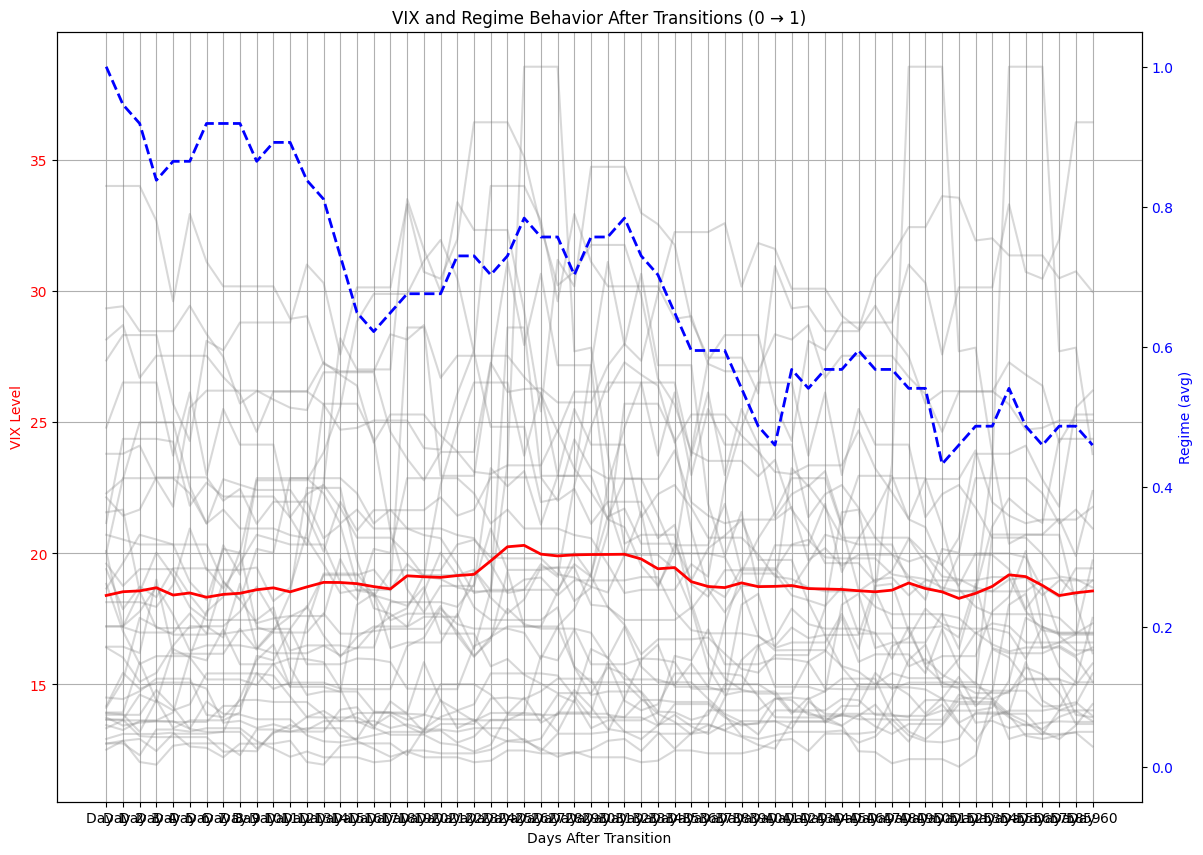

In [1408]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into a model for vix level forecasting

In [1409]:
vix_windows_past_df_train.tail()

Day 1  Day 2      Day 3      Day 4  Day 5  Day 6  Day 7  \
transition_time                                                            
2024-03-30       13.31  14.35  13.880000  13.850000  13.67  13.67  13.67   
2024-05-30       13.19  13.19  13.240000  12.780000  13.01  13.65  13.65   
2024-06-09       14.33  16.35  16.030001  15.190000  15.19  15.19  14.98   
2024-06-15       14.98  15.80  14.910000  17.309999  19.23  19.23  19.23   
2024-07-08       14.68  13.49  13.490000  13.490000  13.49  13.23  13.00   

                 Day 8      Day 9     Day 10  ...  Day 51  Day 52  Day 53  \
transition_time                               ...                           
2024-03-30       13.06  12.830000  12.790000  ...   13.04   12.92   13.06   
2024-05-30       13.65  13.650000  14.610000  ...   13.60   13.42   12.45   
2024-06-09       15.80  14.910000  17.309999  ...   14.47   12.92   13.11   
2024-06-15       18.40  18.209999  18.000000  ...   12.63   12.58   12.22   
2024-07-08       12.69  12.550000  13.600000  ...   12.44   12.22   12.22   

                 Day 54  Day 55  Day 56  Day 57  Day 58  Day 59  Day 60  
transition_time                                                          
2024-03-30        13.19   13.19   13.19   13.24   12.78   13.01   13.65  
2024-05-30        12.42   11.99   12.15   12.15   12.15   11.86   12.29  
2024-06-09        13.11   13.11   13.16   12.63   12.58   12.22   12.74  
2024-06-15        12.74   12.74   12.74   12.85   12.04   11.94   12.66  
2024-07-08        12.22   12.03   12.09   12.48   12.48   12.37   12.37  

[5 rows x 60 columns]

In [1410]:
vix_windows_df_train.iloc[-1].max()

np.float64(38.56999969482422)

In [1411]:
df_delayed_spike_prob, clf_delayed_spike_prob, vix_pct_change_lookback_df_train = macro_utils.clf_delayed_spike_prob(vix_windows_df_train, df_model, "vix_target")

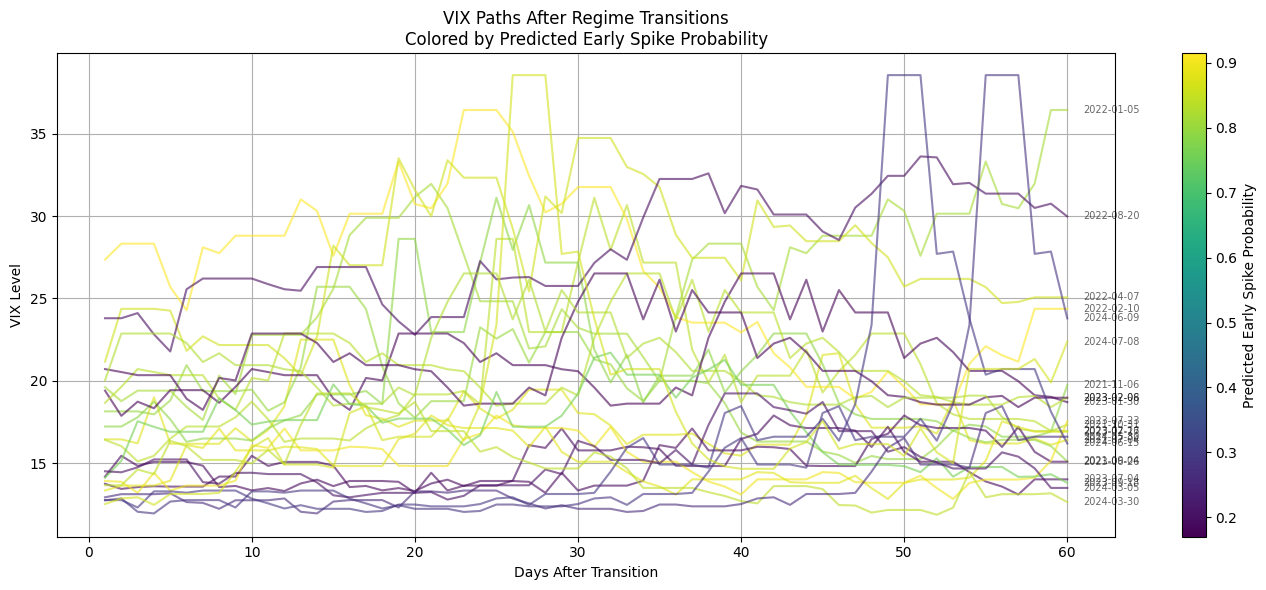

In [1412]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [1413]:
vix_windows_df_train.tail()

Day 1  Day 2  Day 3  Day 4  Day 5      Day 6  Day 7  Day 8  \
transition_time                                                               
2024-03-30       13.65  13.65  14.61  14.33  16.35  16.030001  15.19  15.19   
2024-05-30       12.92  13.11  13.11  13.11  13.16  12.630000  12.58  12.22   
2024-06-09       12.74  12.85  12.04  11.94  12.66  12.750000  12.75  12.75   
2024-06-15       12.75  12.75  12.30  13.28  13.28  13.200000  13.33  13.33   
2024-07-08       12.51  12.85  12.92  12.46  13.12  13.120000  13.12  13.19   

                 Day 9  Day 10  ...     Day 52  Day 53     Day 54     Day 55  \
transition_time                 ...                                            
2024-03-30       15.19   14.98  ...  11.860000   12.29  14.470000  12.920000   
2024-05-30       12.74   12.74  ...  14.910000   14.91  14.720000  18.040001   
2024-06-09       12.30   13.28  ...  16.360001   18.59  23.389999  38.570000   
2024-06-15       13.33   12.84  ...  27.709999   27.85  23.790001  20.370001   
2024-07-08       14.48   15.93  ...  15.650000   15.00  20.719999  20.719999   

                    Day 56     Day 57     Day 58     Day 59     Day 60  \
transition_time                                                          
2024-03-30       13.110000  13.110000  13.110000  13.160000  12.630000   
2024-05-30       18.459999  16.389999  16.600000  16.600000  16.600000   
2024-06-09       38.570000  38.570000  27.709999  27.850000  23.790001   
2024-06-15       20.709999  20.709999  20.709999  18.120001  16.190001   
2024-07-08       20.719999  20.719999  21.320000  19.900000  22.379999   

                 early_spike_prob  
transition_time                    
2024-03-30                 0.8400  
2024-05-30                 0.2575  
2024-06-09                 0.2825  
2024-06-15                 0.2850  
2024-07-08                 0.8650  

[5 rows x 61 columns]

because of randomness, we will just predict peak, half decay time, and rising time.

In [1414]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news = train_df.copy()                       # original df you posted   # string/ts column → index
news = news.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats = engineer_news_feats(news)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats.index = pd.to_datetime(news_feats.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats.index.min(),
                          news_feats.index.max(),
                          freq='D')

news_dense = (
    news_feats
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/4146476144.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()                 # carry last known sentiment forward


In [1415]:
train_df.tail()

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2024-10-11     -0.313376    -0.972448                 58      -0.157393   
2024-10-12      0.181630    -0.959148                  9       0.054226   
2024-10-13     -0.280690    -0.969393                 10      -0.232838   
2024-10-14      0.009047    -0.974299                 24      -0.044218   
2024-10-15     -0.242439    -0.975493                 63      -0.210137   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2024-10-11     -0.971905                  57                  48   
2024-10-12     -0.946041                  31                   6   
2024-10-13     -0.916358                  12                   8   
2024-10-14     -0.972195                  43                  20   
2024-10-15     -0.972273                  74                  56   

            overall_mean  overall_min  overall_pos_count  ...  vix_target  \
date                                                      ...               
2024-10-11     -0.235385    -0.972176                104  ...   20.459999   
2024-10-12      0.117928    -0.952595                 59  ...   19.700001   
2024-10-13     -0.256764    -0.942875                 22  ...   19.700001   
2024-10-14     -0.017585    -0.973247                 82  ...   19.700001   
2024-10-15     -0.226288    -0.973883                141  ...   20.639999   

            mean_sentiment_decay  shock_neg  sentiment_dominance  \
date                                                               
2024-10-11             -0.085379  -0.972176                  -11   
2024-10-12             -0.235385  -0.952595                   19   
2024-10-13              0.117928  -0.942875                    0   
2024-10-14             -0.256764  -0.973247                   15   
2024-10-15             -0.017585  -0.973883                    4   

            dominance_trigger  vix_7d_pct  vix_zscore   ewm_mean   ewm_std  \
date                                                                         
2024-10-11                  1    0.331165    0.993342  19.186137  2.634178   
2024-10-12                  0    0.161557    0.630209  19.221576  2.545179   
2024-10-13                  0    0.177525    0.587371  19.254571  2.458947   
2024-10-14                  0    0.177525    0.550558  19.285290  2.375424   
2024-10-15                  0    0.233712    0.892232  19.378718  2.318554   

            vix_ewm_zscore  
date                        
2024-10-11        0.483590  
2024-10-12        0.187973  
2024-10-13        0.181147  
2024-10-14        0.174584  
2024-10-15        0.543995  

[5 rows x 21 columns]

In [1427]:
# ------------------------------------------------------------
# 3)  BUILD ARC‑LEVEL TABLE  (robust to missing news dates)
# ------------------------------------------------------------
records = []
for dt, row in vix_windows_df_train.iterrows():
    v = row[[f'Day {i}' for i in range(1, 61)]].values
    r = regime_windows_df_train.loc[dt, [f'Day {i}' for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur            = peak_idx - start_idx
    decay_idx           = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life           = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest‑past news features --------
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    records.append({
        "date_start": dt_norm,
        "peak_vix":  peak_val,
        "vix0":      start_val,
        "T_up":      rise_dur,
        "T_half":    half_life,
        **feats_on_start
    })

arc_df = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)
print(arc_df.T.iloc[0])


arc_df shape: (37, 27)
date_start
2021-07-04    22.500000
2021-08-17    21.670000
2021-09-04    25.709999
2021-10-31    16.030001
2021-11-06    31.120001
2022-01-05    31.959999
2022-02-10    36.450001
2022-04-07    34.750000
2022-05-18    29.450001
2022-06-10    34.020000
2022-06-28    28.709999
2022-08-20    33.630001
2022-12-07    25.000000
2022-12-27    22.900000
2023-01-30    17.870001
2023-02-06    18.660000
2023-02-08    20.530001
2023-02-16    22.870001
2023-03-09    26.520000
2023-04-25    17.030001
2023-05-03    17.990000
2023-05-20    20.030001
2023-06-26    13.740000
2023-07-04    15.440000
2023-07-23    13.860000
2023-07-27    17.889999
2023-09-18    21.709999
2023-12-19    14.130000
2024-01-13    14.790000
2024-01-24    14.350000
2024-02-10    15.850000
2024-03-05    15.220000
2024-03-30    19.230000
2024-05-30    13.160000
2024-06-09    12.850000
2024-06-15    13.330000
2024-07-08    38.570000
Name: peak_vix, dtype: float64


In [1428]:
arc_df['early_spike_prob'] = vix_windows_df_train['early_spike_prob']

In [1429]:
arc_df = arc_df.fillna(-1)

In [1430]:
arc_df = arc_df.drop(columns=['vix_target'])

In [1431]:
len(arc_df.columns)

27

In [1498]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

mlp_params = dict(
    hidden_layer_sizes=(64,32),
    activation="relu",
    learning_rate_init=1e-3,   # ↑ a bit
    alpha=1e-2,                # much weaker L2
    max_iter=2000,
    batch_size=4,
    early_stopping=True, 
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
)

# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full = arc_df[feature_cols].values
y_full = arc_df[target_cols].values
tscv   = TimeSeriesSplit(n_splits=10)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → MLP, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp",     MLPRegressor(**mlp_params)),
    ])
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=StandardScaler()     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(pipe, X_full, y,
                        cv=tscv,
                        scoring=mae_scorer,
                        n_jobs=-1,
                        return_train_score=False)
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"mlp_{col}.pkl")

print("\nSaved pickled models:", [f"mlp_{c}.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {col: float(models[col].predict(row_df[feature_cols].values))
             for col in target_cols}
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


Python(46695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46696) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46700) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, U

peak_vix | MAE (5-fold): 6.725


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.ven

T_up     | MAE (5-fold): 9.358


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.ven

T_half   | MAE (5-fold): 11.533

Saved pickled models: ['mlp_peak_vix.pkl', 'mlp_T_up.pkl', 'mlp_T_half.pkl']


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.ven

# XGBoost

In [1499]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor

# Define targets and features
target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

# XGBoost parameters (adjust as needed)

xgb_params = {
    "n_estimators": 50,           # very few trees
    "max_depth": 2,               # extremely shallow
    "learning_rate": 0.01,        # slow learning
    "subsample": 0.7,             # random row sampling
    "colsample_bytree": 0.7,      # random feature sampling
    "reg_alpha": 1.0,             # strong L1 regularization
    "reg_lambda": 1.0,            # strong L2 regularization
    "random_state": 42
}


# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full = arc_df[feature_cols].values
y_full = arc_df[target_cols].values
tscv   = TimeSeriesSplit(n_splits=5)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → XGBoost, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("xgb",     XGBRegressor(**xgb_params)),
    ])
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=StandardScaler()     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(
        pipe, X_full, y,
        cv=tscv,
        scoring=mae_scorer,
        n_jobs=-1,
        return_train_score=False
    )
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"xgb_{col}.pkl")

print("\nSaved pickled models:", [f"xgb_{c}.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {
        col: float(models[col].predict(row_df[feature_cols].values))
        for col in target_cols
    }
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


peak_vix | MAE (5-fold): 7.079
T_up     | MAE (5-fold): 7.938
T_half   | MAE (5-fold): 11.515

Saved pickled models: ['xgb_peak_vix.pkl', 'xgb_T_up.pkl', 'xgb_T_half.pkl']


# Hyperparameter tuning

In [1500]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor

# 1) Cross‐validation & scoring
tscv       = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 2) Tighter parameter distributions
param_dist = {
    "regressor__xgb__n_estimators":    [10, 20, 30, 50],
    "regressor__xgb__max_depth":       [1, 2, 3],
    "regressor__xgb__learning_rate":   [0.01, 0.05, 0.1],
    "regressor__xgb__subsample":       [0.5, 0.7],
    "regressor__xgb__colsample_bytree":[0.5, 0.7],
    "regressor__xgb__gamma":           [0, 1],
    "regressor__xgb__reg_alpha":       [1, 10],
    "regressor__xgb__reg_lambda":      [1, 10],
}

# 3) Hold your tuned pipelines and CV scores
tuned_models = {}
tuned_cv_mae = {}

for col in target_cols:
    y = y_full[:, target_cols.index(col)]

    # Build fresh pipeline for each target
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("xgb",     XGBRegressor(random_state=42, use_label_encoder=False, verbosity=0)),
    ])
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=StandardScaler()
    )

    # Randomized search—with far fewer iterations
    search = RandomizedSearchCV(
        estimator           = pipe,
        param_distributions = param_dist,
        n_iter              = 50,               # ← much smaller
        cv                  = tscv,
        scoring             = mae_scorer,
        n_jobs              = -1,
        random_state        = 42,
        verbose             = 1,
        return_train_score  = False
    )

    search.fit(X_full, y)
    best_mae = -search.best_score_
    print(f"{col:8s} | best MAE (TS CV): {best_mae:.3f}")
    print(" best params:", search.best_params_)

    tuned_models[col] = search.best_estimator_
    tuned_cv_mae[col] = best_mae

    # Save the constrained, tuned pipeline
    joblib.dump(search.best_estimator_, f"xgb_{col}_tuned_constrained.pkl")

print("\nDone. Saved:", [f"xgb_{c}_tuned_constrained.pkl" for c in target_cols])


Fitting 5 folds for each of 50 candidates, totalling 250 fits
peak_vix | best MAE (TS CV): 6.254
 best params: {'regressor__xgb__subsample': 0.5, 'regressor__xgb__reg_lambda': 10, 'regressor__xgb__reg_alpha': 1, 'regressor__xgb__n_estimators': 50, 'regressor__xgb__max_depth': 1, 'regressor__xgb__learning_rate': 0.1, 'regressor__xgb__gamma': 0, 'regressor__xgb__colsample_bytree': 0.5}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
T_up     | best MAE (TS CV): 7.445
 best params: {'regressor__xgb__subsample': 0.5, 'regressor__xgb__reg_lambda': 10, 'regressor__xgb__reg_alpha': 1, 'regressor__xgb__n_estimators': 20, 'regressor__xgb__max_depth': 3, 'regressor__xgb__learning_rate': 0.1, 'regressor__xgb__gamma': 0, 'regressor__xgb__colsample_bytree': 0.7}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
T_half   | best MAE (TS CV): 10.570
 best params: {'regressor__xgb__subsample': 0.5, 'regressor__xgb__reg_lambda': 10, 'regressor__xgb__reg_alpha': 1, 'regressor__x

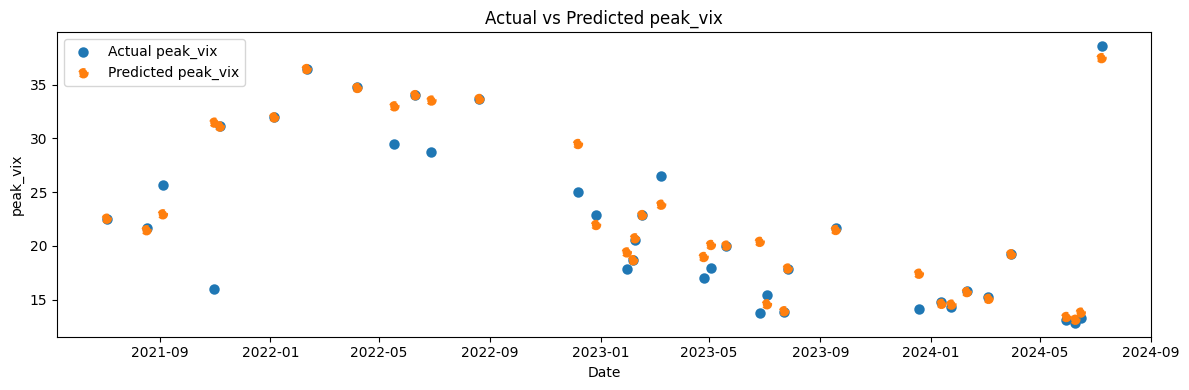

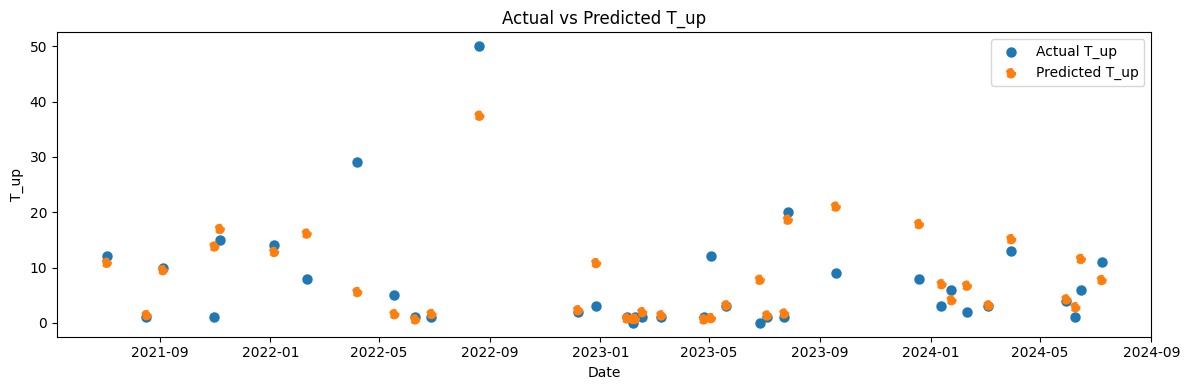

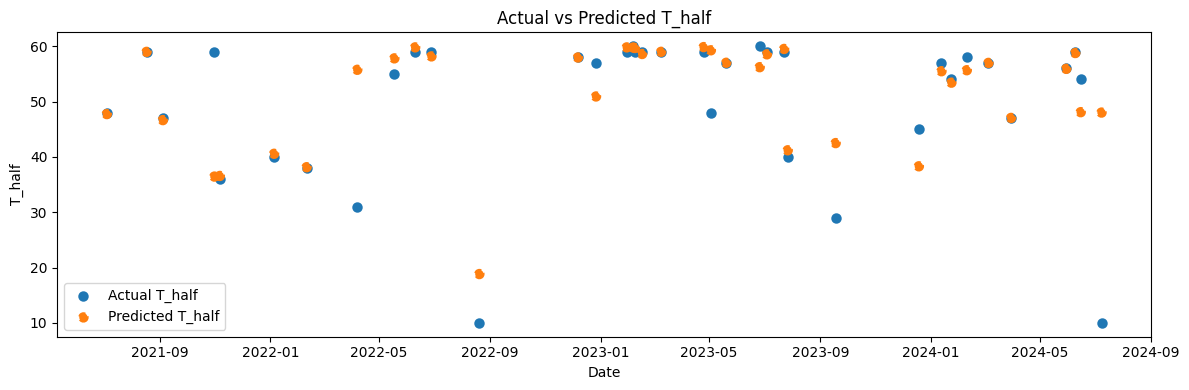

In [1501]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index         # x‑axis

models = {
    "peak_vix": joblib.load("xgb_peak_vix_tuned.pkl"),
    "T_up":     joblib.load("xgb_T_up_tuned.pkl"),
    "T_half":   joblib.load("xgb_T_half_tuned.pkl"),
}

for target, model in models.items():
    y_true = arc_df[target].values
    y_pred = model.predict(X_full)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


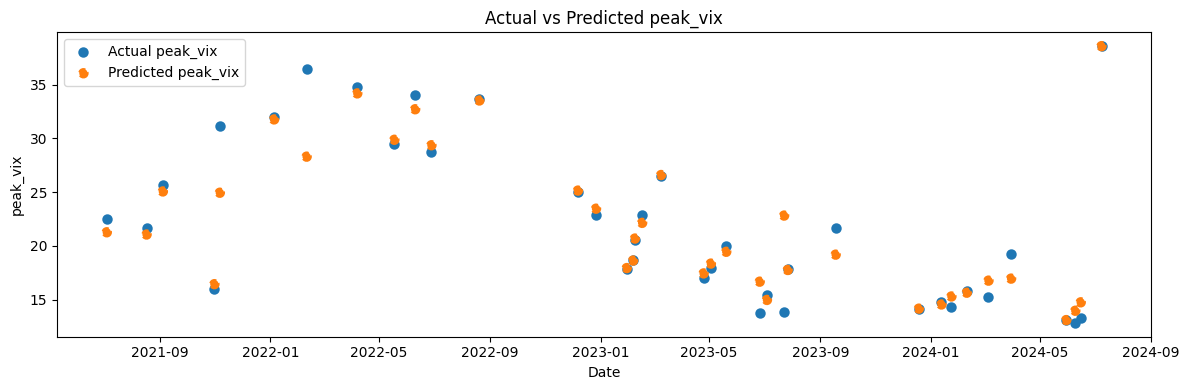

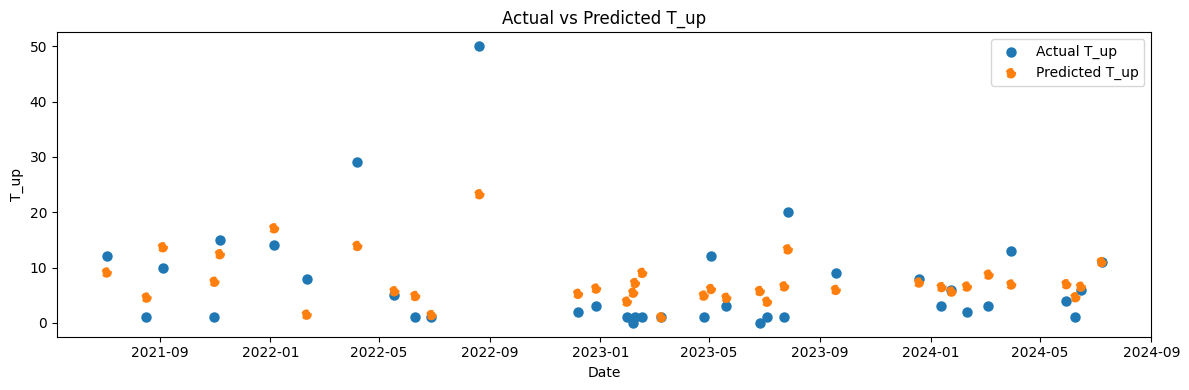

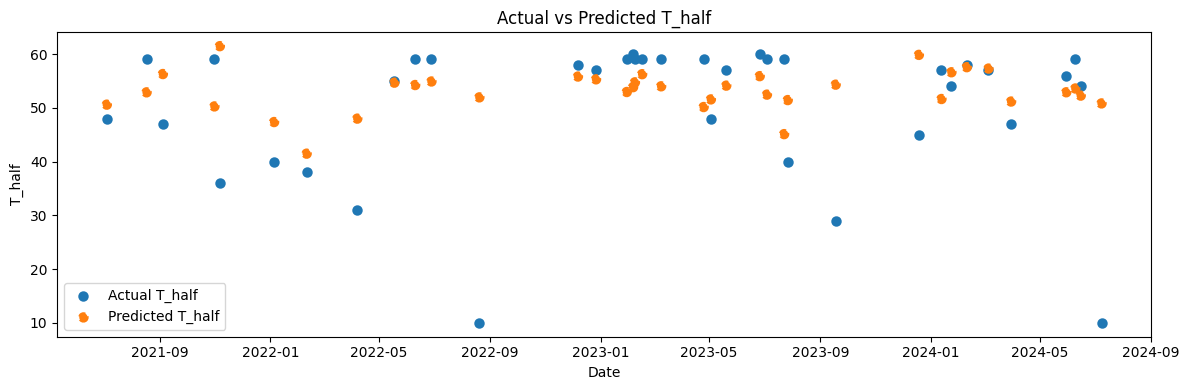

In [1502]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true = arc_df[target].values
    y_pred = model.predict(X_full)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Test Set on models (regime + panic probability)


In [1437]:
vix_windows_df_train.head()

Day 1      Day 2      Day 3      Day 4      Day 5  \
transition_time                                                          
2021-07-04       16.440001  16.440001  16.200001  19.000000  16.180000   
2021-08-17       21.570000  21.670000  18.559999  17.150000  17.150000   
2021-09-04       18.139999  18.139999  18.139999  17.959999  18.799999   
2021-10-31       16.410000  16.030001  15.100000  15.440000  16.480000   
2021-11-06       17.219999  17.219999  17.780001  18.730000  17.660000   

                     Day 6      Day 7      Day 8      Day 9     Day 10  ...  \
transition_time                                                         ...   
2021-07-04       16.170000  16.170000  16.170000  17.120001  16.330000  ...   
2021-08-17       17.150000  17.219999  16.790001  18.840000  16.389999  ...   
2021-09-04       20.950001  19.370001  19.370001  19.370001  19.459999  ...   
2021-10-31       17.219999  17.219999  17.219999  17.780001  18.730000  ...   
2021-11-06       16.290001  16.490000  16.490000  16.490000  16.370001  ...   

                    Day 52     Day 53     Day 54     Day 55     Day 56  \
transition_time                                                          
2021-07-04       16.790001  18.840000  16.389999  16.190001  16.190001   
2021-08-17       18.770000  20.000000  20.000000  20.000000  19.850000   
2021-09-04       15.980000  16.980000  16.530001  16.260000  16.410000   
2021-10-31       18.629999  17.959999  17.680000  17.680000  17.680000   
2021-11-06       17.540001  16.950001  17.330000  17.219999  16.600000   

                    Day 57     Day 58     Day 59     Day 60  early_spike_prob  
transition_time                                                                
2021-07-04       16.190001  16.480000  16.110001  16.410000            0.8775  
2021-08-17       18.639999  16.860001  16.299999  16.309999               NaN  
2021-09-04       16.410000  16.410000  16.030001  15.100000            0.8000  
2021-10-31       17.680000  17.540001  16.950001  17.330000            0.8375  
2021-11-06       16.600000  16.600000  16.910000  19.730000            0.7875  

[5 rows x 61 columns]

In [1438]:
print(results.params)

p[0->0]     0.929804
p[1->0]     0.070466
p[2->0]     0.000066
p[0->1]     0.063617
p[1->1]     0.848595
p[2->1]     0.134483
const[0]   -0.807728
const[1]    0.037618
const[2]    1.299437
x1[0]       0.034749
x1[1]       0.091370
x1[2]       0.107262
x2[0]       0.048388
x2[1]       0.044731
x2[2]       0.189721
sigma2      0.183971
dtype: float64


In [1439]:
# 1. After fitting on training set
train_params = results.params


X_test = test_df[selected_features]
y_test = test_df['vix_ewm_zscore']

# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=3,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda r: 1 if r in [1, 2] else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)



/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/1962623518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/1962623518.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [1440]:
test_df.tail()

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2025-04-12     -0.089461    -0.957227                 43      -0.008691   
2025-04-13     -0.086733    -0.972444                 31      -0.158017   
2025-04-14     -0.063972    -0.972737                123      -0.219557   
2025-04-15     -0.174286    -0.975042                117      -0.138407   
2025-04-16     -0.254442    -0.974785                169      -0.164961   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2025-04-12     -0.941981                 105                  28   
2025-04-13     -0.968547                  71                  34   
2025-04-14     -0.973235                 208                 154   
2025-04-15     -0.974432                 195                 103   
2025-04-16     -0.974998                 247                 127   

            overall_mean  overall_min  overall_pos_count  ...  \
date                                                      ...   
2025-04-12     -0.049076    -0.949604                195  ...   
2025-04-13     -0.122375    -0.970495                145  ...   
2025-04-14     -0.141765    -0.972986                447  ...   
2025-04-15     -0.156347    -0.974737                376  ...   
2025-04-16     -0.209701    -0.974891                452  ...   

            dominance_trigger  vix_7d_pct  vix_zscore   ewm_mean    ewm_std  \
date                                                                          
2025-04-12                  0    0.426790    0.340215  30.907810  11.605613   
2025-04-13                  0    0.386445    0.313508  30.906581  11.198272   
2025-04-14                  0    0.386445    0.283756  30.905438  10.805228   
2025-04-15                  0    0.351885    0.185777  30.851270  10.427948   
2025-04-16                  0    0.499311    0.382230  30.974630  10.072522   

            vix_ewm_zscore  regime_t_raw  regime_t  panic_prob_t+1  \
date                                                                 
2025-04-12       -0.001535             1         1        0.732124   
2025-04-13       -0.001481             1         1        0.668916   
2025-04-14       -0.001429             1         1        0.612077   
2025-04-15       -0.070126             1         1        0.554248   
2025-04-16        0.165338             1         1        0.490186   

            vix_target_t+1  
date                        
2025-04-12       30.889999  
2025-04-13       30.889999  
2025-04-14       30.120001  
2025-04-15       32.639999  
2025-04-16             NaN  

[5 rows x 25 columns]

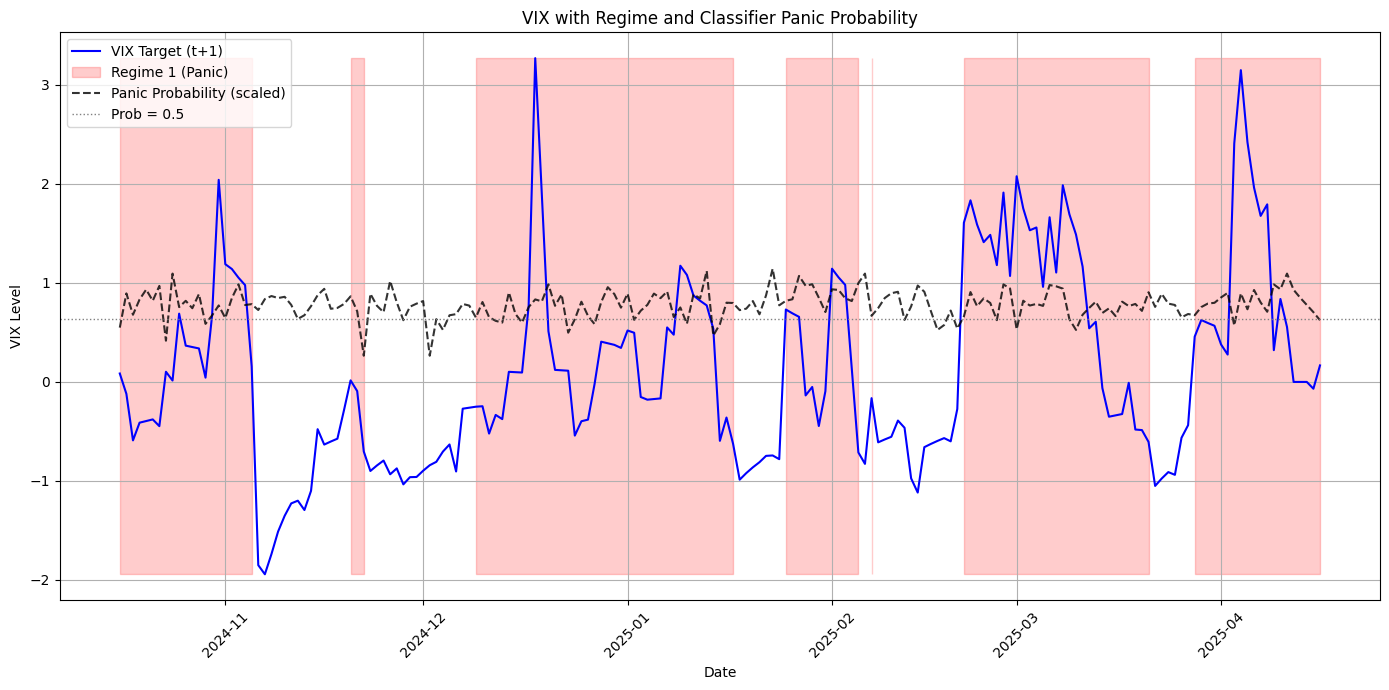

In [1441]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_ewm_zscore"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_ewm_zscore"].min(),
    test_df["vix_ewm_zscore"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_ewm_zscore"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_ewm_zscore"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

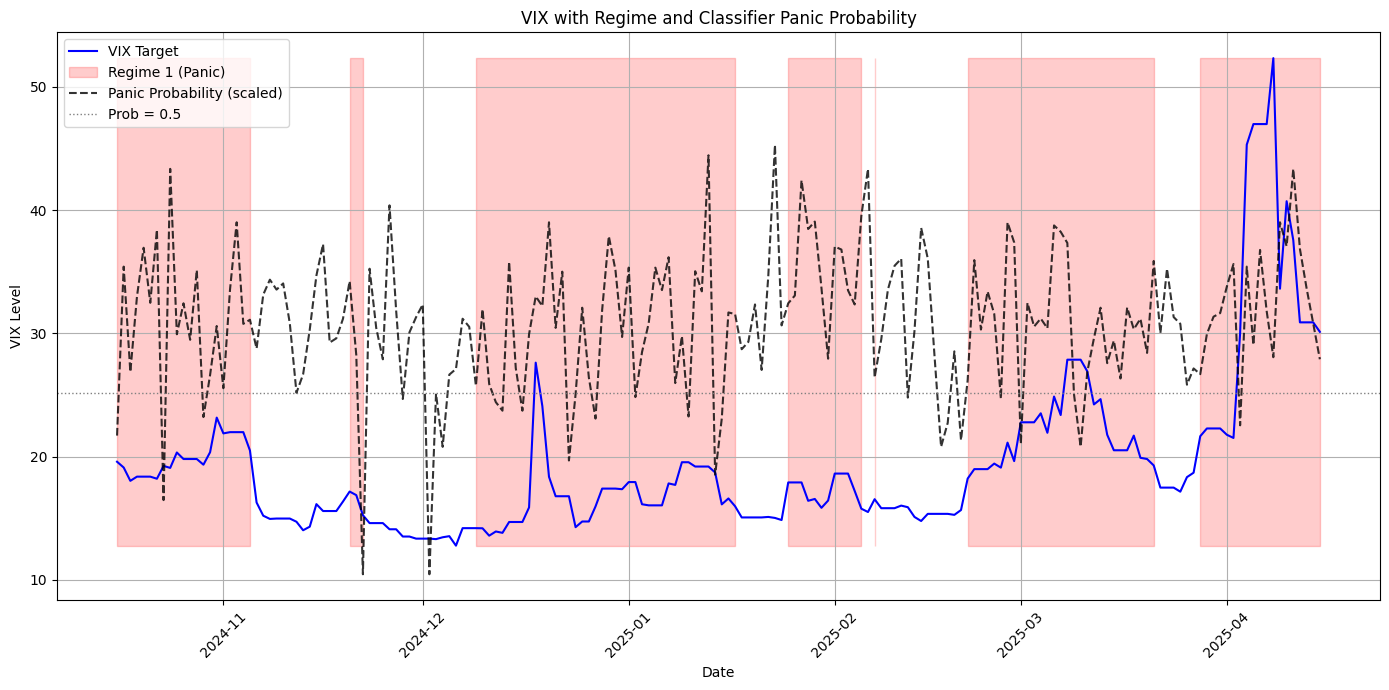

In [1210]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target"], label="VIX Target", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target"].min(),
    test_df["vix_target"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1442]:
test_df.head()

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2024-10-16     -0.222685    -0.976018                 47      -0.167496   
2024-10-17     -0.224310    -0.974795                 34      -0.272826   
2024-10-18     -0.248795    -0.973813                 27      -0.209752   
2024-10-19      0.076486    -0.904173                  5      -0.051621   
2024-10-20     -0.148248    -0.970708                 11       0.232043   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2024-10-16     -0.971121                  51                  40   
2024-10-17     -0.973557                  36                  40   
2024-10-18     -0.970884                  28                  22   
2024-10-19     -0.936994                  13                   4   
2024-10-20     -0.928842                  25                   4   

            overall_mean  overall_min  overall_pos_count  ...  \
date                                                      ...   
2024-10-16     -0.195090    -0.973569                 95  ...   
2024-10-17     -0.248568    -0.974176                 78  ...   
2024-10-18     -0.229274    -0.972349                 51  ...   
2024-10-19      0.012432    -0.920584                 25  ...   
2024-10-20      0.041897    -0.949775                 43  ...   

            dominance_trigger  vix_7d_pct  vix_zscore   ewm_mean   ewm_std  \
date                                                                         
2024-10-16                  0    0.016615    0.412830  19.392600  2.237779   
2024-10-17                  0    0.011111    0.193659  19.373110  2.160467   
2024-10-18                  0   -0.120059   -0.260678  19.280482  2.113252   
2024-10-19                  0   -0.043727   -0.148076  19.217690  2.052570   
2024-10-20                  0   -0.188604   -0.183860  19.159229  1.992570   

            vix_ewm_zscore  regime_t_raw  regime_t  panic_prob_t+1  \
date                                                                 
2024-10-16        0.083744             1         1        0.431188   
2024-10-17       -0.121784             1         1        0.703590   
2024-10-18       -0.591733             1         1        0.533670   
2024-10-19       -0.412989             1         1        0.655456   
2024-10-20       -0.396085             1         1        0.734008   

            vix_target_t+1  
date                        
2024-10-16       19.110001  
2024-10-17       18.030001  
2024-10-18       18.370001  
2024-10-19       18.370001  
2024-10-20       18.370001  

[5 rows x 25 columns]

In [1443]:
classification_df_test = macro_utils.identify_sustained_regimes_and_transitions(test_df)

/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['is_transition'] = (
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [1444]:
classification_df_test

summary_mean  summary_min  summary_neg_count  headline_mean  \
date                                                                      
2024-10-16     -0.222685    -0.976018                 47      -0.167496   
2024-10-17     -0.224310    -0.974795                 34      -0.272826   
2024-10-18     -0.248795    -0.973813                 27      -0.209752   
2024-10-19      0.076486    -0.904173                  5      -0.051621   
2024-10-20     -0.148248    -0.970708                 11       0.232043   
...                  ...          ...                ...            ...   
2025-04-12     -0.089461    -0.957227                 43      -0.008691   
2025-04-13     -0.086733    -0.972444                 31      -0.158017   
2025-04-14     -0.063972    -0.972737                123      -0.219557   
2025-04-15     -0.174286    -0.975042                117      -0.138407   
2025-04-16     -0.254442    -0.974785                169      -0.164961   

            headline_min  headline_pos_count  headline_neg_count  \
date                                                               
2024-10-16     -0.971121                  51                  40   
2024-10-17     -0.973557                  36                  40   
2024-10-18     -0.970884                  28                  22   
2024-10-19     -0.936994                  13                   4   
2024-10-20     -0.928842                  25                   4   
...                  ...                 ...                 ...   
2025-04-12     -0.941981                 105                  28   
2025-04-13     -0.968547                  71                  34   
2025-04-14     -0.973235                 208                 154   
2025-04-15     -0.974432                 195                 103   
2025-04-16     -0.974998                 247                 127   

            overall_mean  overall_min  overall_pos_count  ...    ewm_std  \
date                                                      ...              
2024-10-16     -0.195090    -0.973569                 95  ...   2.237779   
2024-10-17     -0.248568    -0.974176                 78  ...   2.160467   
2024-10-18     -0.229274    -0.972349                 51  ...   2.113252   
2024-10-19      0.012432    -0.920584                 25  ...   2.052570   
2024-10-20      0.041897    -0.949775                 43  ...   1.992570   
...                  ...          ...                ...  ...        ...   
2025-04-12     -0.049076    -0.949604                195  ...  11.605613   
2025-04-13     -0.122375    -0.970495                145  ...  11.198272   
2025-04-14     -0.141765    -0.972986                447  ...  10.805228   
2025-04-15     -0.156347    -0.974737                376  ...  10.427948   
2025-04-16     -0.209701    -0.974891                452  ...  10.072522   

            vix_ewm_zscore  regime_t_raw  regime_t  panic_prob_t+1  \
date                                                                 
2024-10-16        0.083744             1         1        0.431188   
2024-10-17       -0.121784             1         1        0.703590   
2024-10-18       -0.591733             1         1        0.533670   
2024-10-19       -0.412989             1         1        0.655456   
2024-10-20       -0.396085             1         1        0.734008   
...                    ...           ...       ...             ...   
2025-04-12       -0.001535             1         1        0.732124   
2025-04-13       -0.001481             1         1        0.668916   
2025-04-14       -0.001429             1         1        0.612077   
2025-04-15       -0.070126             1         1        0.554248   
2025-04-16        0.165338             1         1        0.490186   

            vix_target_t+1  regime_group  is_sustained_regime1  regime_t-1  \
date                                                                         
2024-10-16       19.110001             1                  True         NaN   
2024-10-17       

In [1459]:
result = macro_utils.transform_vix_data(classification_df_test, window=60, test=True)
vix_windows_df_test = result["vix_windows_df_train"]
regime_windows_df_test = result["regime_windows_df_train"]
vix_windows_past_df_test = result["vix_windows_past_df_train"]

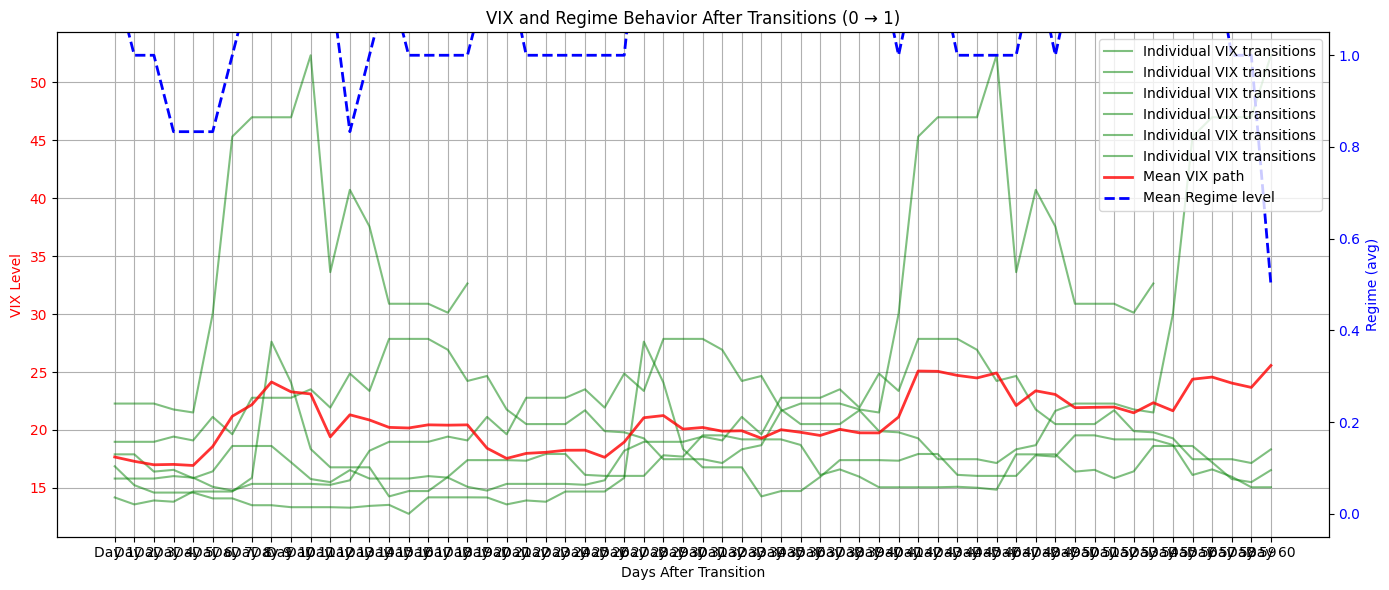

In [1460]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_test.T, color="green", alpha=0.5, label="Individual VIX transitions")
ax1.plot(vix_windows_df_test.mean(axis=0).values, color="red",alpha=0.8, linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_test.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()


In [1465]:
vix_windows_df_test

Day 1      Day 2      Day 3      Day 4  Day 5      Day 6  \
transition_time                                                                 
2024-11-20       16.870001  15.240000  14.600000  14.600000  14.60  14.100000   
2024-12-09       14.180000  13.580000  13.920000  13.810000  14.69  14.690000   
2025-01-25       17.900000  17.900000  16.410000  16.559999  15.84  16.430000   
2025-02-07       15.810000  15.810000  15.810000  16.020000  15.89  15.100000   
2025-02-21       18.980000  18.980000  18.980000  19.430000  19.10  21.129999   
2025-03-28       22.280001  22.280001  22.280001  21.770000  21.51  30.020000   

                     Day 7      Day 8      Day 9     Day 10  ...     Day 52  \
transition_time                                              ...              
2024-11-20       14.100000  13.510000  13.510000  13.340000  ...  19.190001   
2024-12-09       14.690000  15.870000  27.620001  24.090000  ...  15.840000   
2025-01-25       18.620001  18.620001  18.620001  17.209999  ...  21.700001   
2025-02-07       14.770000  15.350000  15.350000  15.350000  ...  22.280001   
2025-02-21       19.629999  22.780001  22.780001  22.780001  ...  30.889999   
2025-03-28       45.310001  46.980000  46.980000  46.980000  ...        NaN   

                    Day 53     Day 54     Day 55     Day 56     Day 57  \
transition_time                                                          
2024-11-20       19.190001  19.190001  18.709999  16.120001  16.600000   
2024-12-09       16.430000  18.620001  18.620001  18.620001  17.209999   
2025-01-25       19.900000  19.799999  19.280001  17.480000  17.480000   
2025-02-07       21.770000  21.510000  30.020000  45.310001  46.980000   
2025-02-21       30.120001  32.639999        NaN        NaN        NaN   
2025-03-28             NaN        NaN        NaN        NaN        NaN   

                 Day 58  Day 59     Day 60  early_spike_prob  
transition_time                                               
2024-11-20        15.97   15.06  15.060000               NaN  
2024-12-09        15.77   15.50  16.540001            0.9350  
2025-01-25        17.48   17.15  18.330000            0.3075  
2025-02-07        46.98   46.98  52.330002            0.8875  
2025-02-21          NaN     NaN        NaN            0.9175  
2025-03-28          NaN     NaN        NaN            0.9325  

[6 rows x 61 columns]

In [1466]:
df_delayed_spike_prob_test, test_clf, test_vix_pct_change_lookback_df = macro_utils.clf_delayed_spike_prob(vix_windows_df_test, test_df, "vix_target")

In [1467]:
df_delayed_spike_prob_test.head()

Day 1  Day 2  Day 3      Day 4  Day 5      Day 6  \
transition_time                                                         
2024-11-20       16.870001  15.24  14.60  14.600000  14.60  14.100000   
2024-12-09       14.180000  13.58  13.92  13.810000  14.69  14.690000   
2025-01-25       17.900000  17.90  16.41  16.559999  15.84  16.430000   
2025-02-07       15.810000  15.81  15.81  16.020000  15.89  15.100000   
2025-02-21       18.980000  18.98  18.98  19.430000  19.10  21.129999   

                     Day 7      Day 8      Day 9     Day 10  ...     Day 52  \
transition_time                                              ...              
2024-11-20       14.100000  13.510000  13.510000  13.340000  ...  19.190001   
2024-12-09       14.690000  15.870000  27.620001  24.090000  ...  15.840000   
2025-01-25       18.620001  18.620001  18.620001  17.209999  ...  21.700001   
2025-02-07       14.770000  15.350000  15.350000  15.350000  ...  22.280001   
2025-02-21       19.629999  22.780001  22.780001  22.780001  ...  30.889999   

                    Day 53     Day 54     Day 55     Day 56     Day 57  \
transition_time                                                          
2024-11-20       19.190001  19.190001  18.709999  16.120001  16.600000   
2024-12-09       16.430000  18.620001  18.620001  18.620001  17.209999   
2025-01-25       19.900000  19.799999  19.280001  17.480000  17.480000   
2025-02-07       21.770000  21.510000  30.020000  45.310001  46.980000   
2025-02-21       30.120001  32.639999        NaN        NaN        NaN   

                 Day 58  Day 59     Day 60  early_spike_prob  
transition_time                                               
2024-11-20        15.97   15.06  15.060000               NaN  
2024-12-09        15.77   15.50  16.540001            0.9350  
2025-01-25        17.48   17.15  18.330000            0.3075  
2025-02-07        46.98   46.98  52.330002            0.8875  
2025-02-21          NaN     NaN        NaN            0.9175  

[5 rows x 61 columns]

In [1468]:
test_vix_pct_change_lookback_df.head()

Day -30   Day -29   Day -28   Day -27   Day -26   Day -25  \
2024-12-09  0.002008  0.000000  0.000000 -0.017368 -0.046907  0.020685   
2025-01-25  0.000000  0.082824  0.090909  0.000000  0.000000 -0.002874   
2025-02-07 -0.006734  0.103955  0.000000 -0.017912  0.000000  0.000000   
2025-02-21  0.002656 -0.005298 -0.011318  0.205387  0.000000  0.000000   
2025-03-28 -0.016984  0.106283 -0.070989  0.160469  0.000000  0.000000   

             Day -24   Day -23   Day -22   Day -21  ...   Day -10    Day -9  \
2024-12-09  0.127883 -0.034696  0.000000  0.000000  ...  0.000000 -0.012583   
2025-01-25  0.033429  0.000000 -0.100390 -0.005580  ... -0.138429  0.029777   
2025-02-07 -0.025013 -0.138429  0.029777 -0.037952  ... -0.083240  0.009141   
2025-02-21 -0.083240  0.009141 -0.043478  0.037247  ...  0.013283 -0.008115   
2025-03-28  0.032046 -0.067205  0.134063 -0.060314  ...  0.058021 -0.082949   

              Day -8    Day -7    Day -6    Day -5    Day -4    Day -3  \
2024-12-09  0.000000  0.000000 -0.002998  0.011278  0.006691 -0.056869   
2025-01-25 -0.037952 -0.056982  0.000000  0.000000  0.000000  0.002656   
2025-02-07 -0.043478  0.037247  0.133293  0.000000  0.000000 -0.075725   
2025-02-21 -0.049717 -0.021854  0.039269  0.000000  0.000000  0.000000   
2025-03-28 -0.005025 -0.026263 -0.093361  0.000000  0.000000 -0.018879   

              Day -2    Day -1  
2024-12-09  0.111198  0.000000  
2025-01-25 -0.005298 -0.011318  
2025-02-07 -0.083672 -0.017121  
2025-02-21 -0.005212  0.025540  
2025-03-28  0.068805  0.019640  

[5 rows x 30 columns]

In [1469]:
df_delayed_spike_prob_test.loc[test_vix_pct_change_lookback_df.index, "early_spike_prob"] = clf_delayed_spike_prob.predict_proba(test_vix_pct_change_lookback_df)[:, 1]


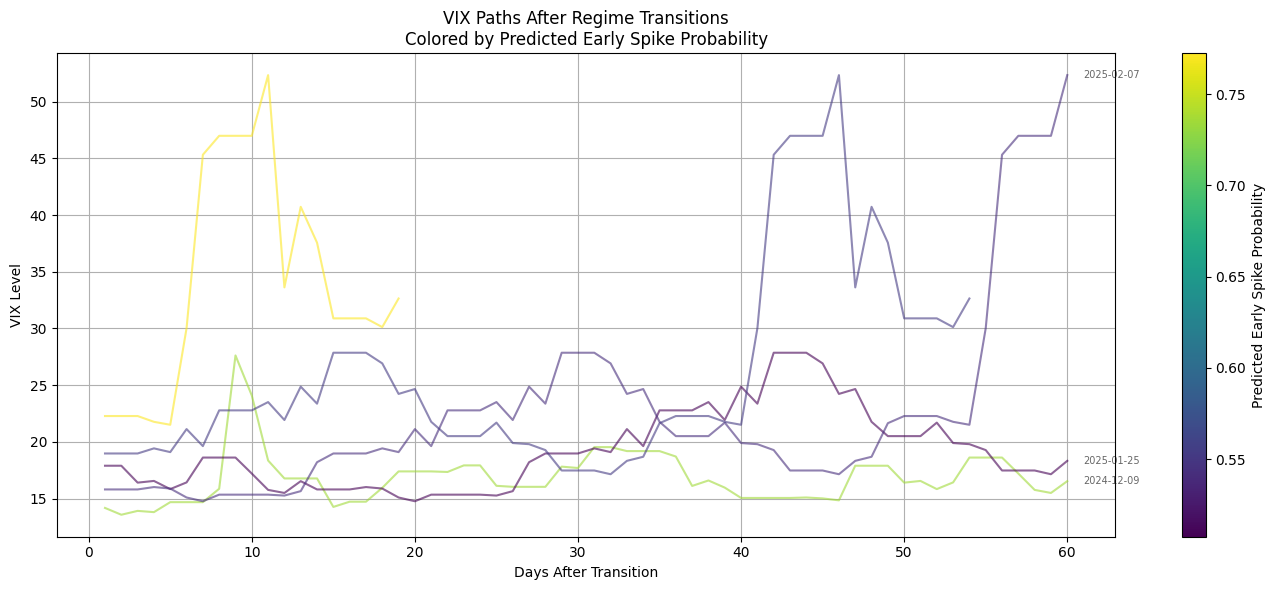

In [1470]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob_test.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [1471]:
df_delayed_spike_prob_test.head()

Day 1  Day 2  Day 3      Day 4  Day 5      Day 6  \
transition_time                                                         
2024-11-20       16.870001  15.24  14.60  14.600000  14.60  14.100000   
2024-12-09       14.180000  13.58  13.92  13.810000  14.69  14.690000   
2025-01-25       17.900000  17.90  16.41  16.559999  15.84  16.430000   
2025-02-07       15.810000  15.81  15.81  16.020000  15.89  15.100000   
2025-02-21       18.980000  18.98  18.98  19.430000  19.10  21.129999   

                     Day 7      Day 8      Day 9     Day 10  ...     Day 52  \
transition_time                                              ...              
2024-11-20       14.100000  13.510000  13.510000  13.340000  ...  19.190001   
2024-12-09       14.690000  15.870000  27.620001  24.090000  ...  15.840000   
2025-01-25       18.620001  18.620001  18.620001  17.209999  ...  21.700001   
2025-02-07       14.770000  15.350000  15.350000  15.350000  ...  22.280001   
2025-02-21       19.629999  22.780001  22.780001  22.780001  ...  30.889999   

                    Day 53     Day 54     Day 55     Day 56     Day 57  \
transition_time                                                          
2024-11-20       19.190001  19.190001  18.709999  16.120001  16.600000   
2024-12-09       16.430000  18.620001  18.620001  18.620001  17.209999   
2025-01-25       19.900000  19.799999  19.280001  17.480000  17.480000   
2025-02-07       21.770000  21.510000  30.020000  45.310001  46.980000   
2025-02-21       30.120001  32.639999        NaN        NaN        NaN   

                 Day 58  Day 59     Day 60  early_spike_prob  
transition_time                                               
2024-11-20        15.97   15.06  15.060000               NaN  
2024-12-09        15.77   15.50  16.540001            0.7350  
2025-01-25        17.48   17.15  18.330000            0.5075  
2025-02-07        46.98   46.98  52.330002            0.5425  
2025-02-21          NaN     NaN        NaN            0.5525  

[5 rows x 61 columns]

In [1472]:
regime_windows_df_test = regime_windows_df_test.replace(2, 1)


In [1473]:
regime_windows_df_test

Day 1  Day 2  Day 3  Day 4  Day 5  Day 6  Day 7  Day 8  \
transition_time                                                           
2024-11-20         1.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0   
2024-12-09         1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
2025-01-25         1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
2025-02-07         1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2025-02-21         1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
2025-03-28         1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   

                 Day 9  Day 10  ...  Day 51  Day 52  Day 53  Day 54  Day 55  \
transition_time                 ...                                           
2024-11-20         0.0     0.0  ...     1.0     1.0     1.0     1.0     1.0   
2024-12-09         1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0   
2025-01-25         1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0   
2025-02-07         0.0     0.0  ...     1.0     1.0     1.0     1.0     1.0   
2025-02-21         1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0   
2025-03-28         1.0     1.0  ...     NaN     NaN     NaN     NaN     NaN   

                 Day 56  Day 57  Day 58  Day 59  Day 60  
transition_time                                          
2024-11-20          1.0     1.0     1.0     1.0     0.0  
2024-12-09          1.0     1.0     1.0     1.0     0.0  
2025-01-25          1.0     0.0     0.0     0.0     0.0  
2025-02-07          1.0     1.0     1.0     1.0     1.0  
2025-02-21          NaN     NaN     NaN     NaN     NaN  
2025-03-28          NaN     NaN     NaN     NaN     NaN  

[6 rows x 60 columns]

In [1503]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = test_df.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_test = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_test.index = pd.to_datetime(news_feats_test.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_test.index.min(),
                          news_feats_test.index.max(),
                          freq='D')

news_dense_test = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



In [1504]:
# ------------------------------------------------------------
# 3)  BUILD ARC‑LEVEL TABLE  (robust to missing news dates)
# ------------------------------------------------------------
records = []
for dt, row in vix_windows_df_test.iterrows():
    v = row[[f'Day {i}' for i in range(1, 61)]].values
    r = regime_windows_df_test.loc[dt, [f'Day {i}' for i in range(1, 61)]].values

    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur            = peak_idx - start_idx
    decay_idx           = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life           = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest‑past news features --------
    try:
        feats_on_start = news_dense_test.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    records.append({
        "date_start": dt_norm,
        "peak_vix":  peak_val,
        "vix0":      start_val,
        "T_up":      rise_dur,
        "T_half":    half_life,
        **feats_on_start
    })

arc_df_test = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df_test.shape)
print(arc_df_test.T.iloc[0].head(10))


arc_df shape: (6, 35)
date_start
2024-11-20    15.240000
2024-12-09    27.620001
2025-01-25    18.620001
2025-02-07    15.810000
2025-02-21    27.860001
2025-03-28          NaN
Name: peak_vix, dtype: float64


/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:348: RuntimeWarning: invalid value encountered in cast
  
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:348: RuntimeWarning: invalid value encountered in cast
  


In [1505]:
arc_df_test['early_spike_prob'] = vix_windows_df_test['early_spike_prob'].fillna(-1)

In [1506]:
# Get column sets
cols_arc_df = set(arc_df.columns)
cols_arc_df_test = set(arc_df_test.columns)

# Columns in arc_df but NOT in arc_df_test
diff_arc_not_test = cols_arc_df - cols_arc_df_test

# Columns in arc_df_test but NOT in arc_df
diff_test_not_arc = cols_arc_df_test - cols_arc_df

# All differing columns
diff_all = cols_arc_df.symmetric_difference(cols_arc_df_test)

# Print results
print("Columns in arc_df but not in arc_df_test:", diff_arc_not_test)
print("Columns in arc_df_test but not in arc_df:", diff_test_not_arc)
print("All differing columns:", diff_all)


Columns in arc_df but not in arc_df_test: set()
Columns in arc_df_test but not in arc_df: {'vix_target', 'regime_t', 'regime_group', 'panic_prob_t+1', 'is_sustained_regime1', 'regime_t-1', 'is_transition', 'vix_target_t+1', 'regime_t_raw'}
All differing columns: {'regime_group', 'vix_target', 'regime_t', 'panic_prob_t+1', 'is_sustained_regime1', 'regime_t-1', 'is_transition', 'vix_target_t+1', 'regime_t_raw'}


In [1507]:
arc_df_test.drop(columns=diff_all, inplace=True)

In [1508]:
arc_df_test['peak_vix'].iloc[-1] = 55

/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/2482282540.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  arc_df_test['peak_vix'].iloc[-1] = 55


In [1509]:
arc_df_test.tail()

peak_vix   vix0  T_up  T_half  summary_mean  summary_min  \
date_start                                                              
2024-12-09  27.620001  14.18   8.0    52.0      0.042288    -0.973634   
2025-01-25  18.620001  17.90   6.0    54.0      0.117867    -0.971038   
2025-02-07  15.810000  15.81   0.0    60.0     -0.215765    -0.975724   
2025-02-21  27.860001  18.98  14.0    46.0     -0.115498    -0.975739   
2025-03-28  55.000000  21.51  15.0    41.0     -0.162400    -0.970411   

            summary_neg_count  headline_mean  headline_min  \
date_start                                                   
2024-12-09               63.0      -0.042489     -0.971553   
2025-01-25                7.0       0.201732     -0.680292   
2025-02-07               50.0       0.037145     -0.975307   
2025-02-21               49.0      -0.161775     -0.971196   
2025-03-28              129.0      -0.077482     -0.974197   

            headline_pos_count  ...  sentiment_dominance  dominance_trigger  \
date_start                      ...                                           
2024-12-09               193.0  ...                120.0                0.0   
2025-01-25                15.0  ...                  6.0                0.0   
2025-02-07                79.0  ...                  6.0                0.0   
2025-02-21                74.0  ...                 25.0                0.0   
2025-03-28               228.0  ...                 69.0                0.0   

            vix_7d_pct  vix_zscore   ewm_mean   ewm_std  vix_ewm_zscore  \
date_start                                                                
2024-12-09   -0.028082   -0.309846  14.708927  2.061672       -0.251702   
2025-01-25   -0.083930    0.623822  16.488420  1.933870        0.729925   
2025-02-07    0.101198   -0.265340  16.792684  1.527895       -0.165380   
2025-02-21    0.174839    1.553746  16.141513  1.287369        1.606754   
2025-03-28   -0.122060   -0.051610  20.214265  3.147856        0.456099   

            dom_0  dom_1  early_spike_prob  
date_start                                  
2024-12-09    1.0    0.0            0.7350  
2025-01-25    1.0    0.0            0.5075  
2025-02-07    1.0    0.0            0.5425  
2025-02-21    1.0    0.0            0.5525  
2025-03-28    1.0    0.0            0.7725  

[5 rows x 27 columns]

In [1510]:
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])


In [1511]:
arc_df_test

peak_vix       vix0  T_up  T_half  summary_mean  summary_min  \
date_start                                                                  
2024-11-20  15.240000  16.870001   1.0    59.0     -0.033441    -0.974451   
2024-12-09  27.620001  14.180000   8.0    52.0      0.042288    -0.973634   
2025-01-25  18.620001  17.900000   6.0    54.0      0.117867    -0.971038   
2025-02-07  15.810000  15.810000   0.0    60.0     -0.215765    -0.975724   
2025-02-21  27.860001  18.980000  14.0    46.0     -0.115498    -0.975739   
2025-03-28  55.000000  21.510000  15.0    41.0     -0.162400    -0.970411   

            summary_neg_count  headline_mean  headline_min  \
date_start                                                   
2024-11-20               53.0       0.014901     -0.973305   
2024-12-09               63.0      -0.042489     -0.971553   
2025-01-25                7.0       0.201732     -0.680292   
2025-02-07               50.0       0.037145     -0.975307   
2025-02-21               49.0      -0.161775     -0.971196   
2025-03-28              129.0      -0.077482     -0.974197   

            headline_pos_count  ...  sentiment_dominance  dominance_trigger  \
date_start                      ...                                           
2024-11-20               105.0  ...                 40.0                0.0   
2024-12-09               193.0  ...                120.0                0.0   
2025-01-25                15.0  ...                  6.0                0.0   
2025-02-07                79.0  ...                  6.0                0.0   
2025-02-21                74.0  ...                 25.0                0.0   
2025-03-28               228.0  ...                 69.0                0.0   

            vix_7d_pct  vix_zscore   ewm_mean   ewm_std  vix_ewm_zscore  \
date_start                                                                
2024-11-20   -0.162518   -0.274723  17.123122  2.596384        0.014203   
2024-12-09   -0.028082   -0.309846  14.708927  2.061672       -0.251702   
2025-01-25   -0.083930    0.623822  16.488420  1.933870        0.729925   
2025-02-07    0.101198   -0.265340  16.792684  1.527895       -0.165380   
2025-02-21    0.174839    1.553746  16.141513  1.287369        1.606754   
2025-03-28   -0.122060   -0.051610  20.214265  3.147856        0.456099   

            dom_0  dom_1  early_spike_prob  
date_start                                  
2024-11-20    1.0    0.0           -1.0000  
2024-12-09    1.0    0.0            0.7350  
2025-01-25    1.0    0.0            0.5075  
2025-02-07    1.0    0.0            0.5425  
2025-02-21    1.0    0.0            0.5525  
2025-03-28    1.0    0.0            0.7725  

[6 rows x 27 columns]

In [1512]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

mlp_params = dict(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    learning_rate_init=1e-4,   # ↑ a bit
    alpha=1e-2,                # much weaker L2
    max_iter=2000,
    batch_size=4,
    early_stopping=True,      # let it run full epochs
    random_state=42,
)

# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full_test = arc_df_test.reindex(columns=feature_cols).values
y_full = arc_df_test[target_cols].values
tscv   = TimeSeriesSplit(n_splits=2)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → MLP, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp",     MLPRegressor(**mlp_params)),
    ])
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=StandardScaler()     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(pipe, X_full, y,
                        cv=tscv,
                        scoring=mae_scorer,
                        n_jobs=-1,
                        return_train_score=False)
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"mlp_{col}_test.pkl")

print("\nSaved pickled models:", [f"mlp_{c}_test.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {col: float(models[col].predict(row_df[feature_cols].values))
             for col in target_cols}
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


ValueError: Found input variables with inconsistent numbers of samples: [37, 6]

In [1513]:
print(list(feature_cols))
print(list(arc_df_test.reindex(columns=feature_cols).columns))


['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_std', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'shock_neg', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_zscore']
['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_std', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'shock_neg', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_zscore']


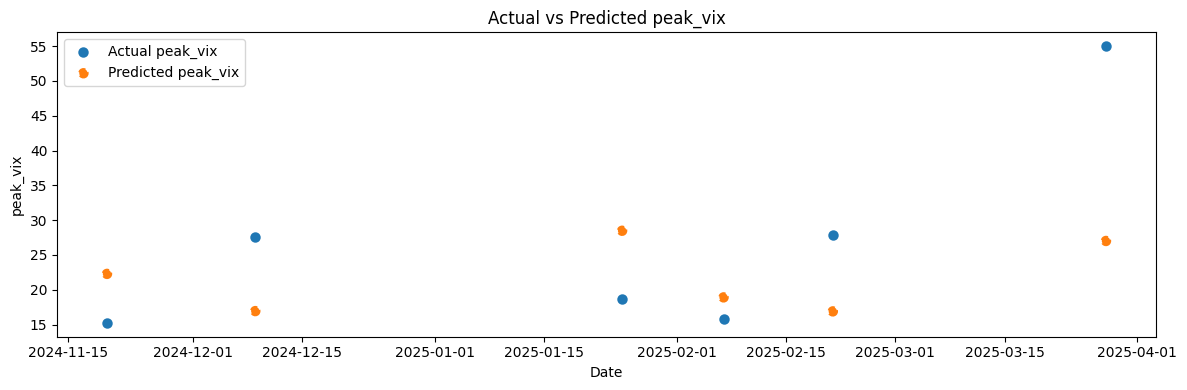

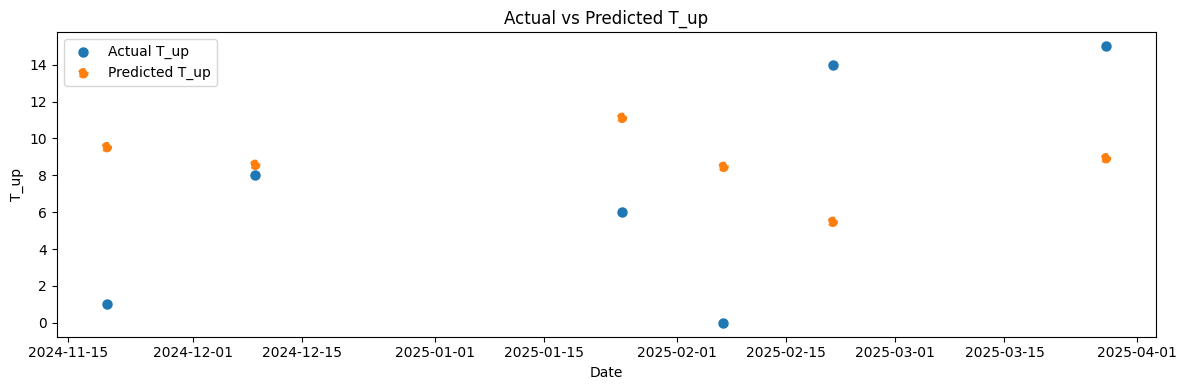

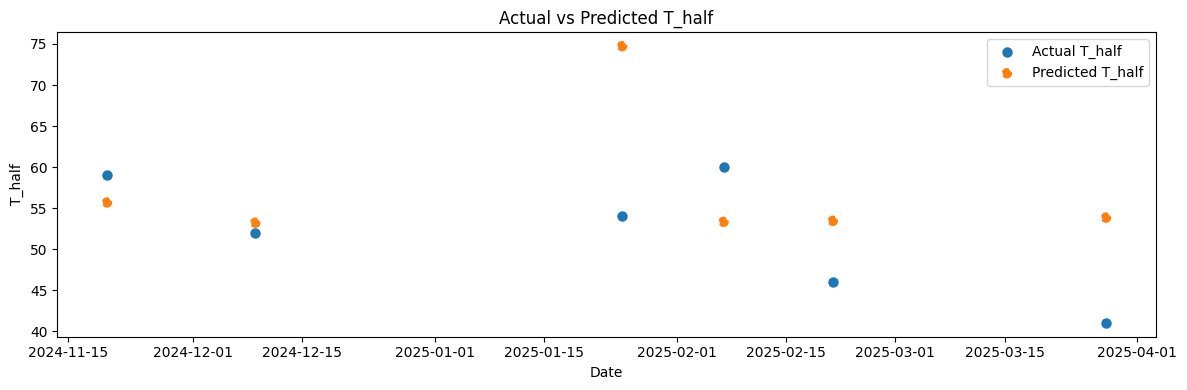

In [1515]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test = arc_df_test.reindex(columns=feature_cols).values

dates = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# XGBoost graph

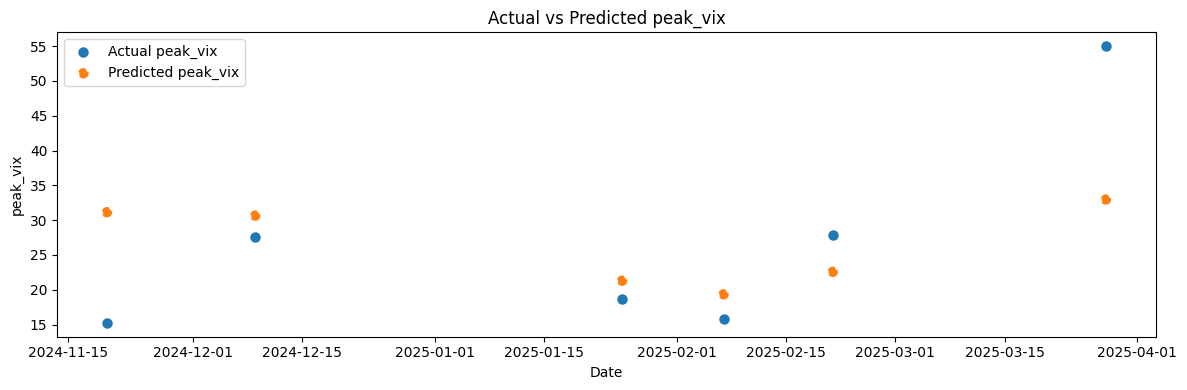

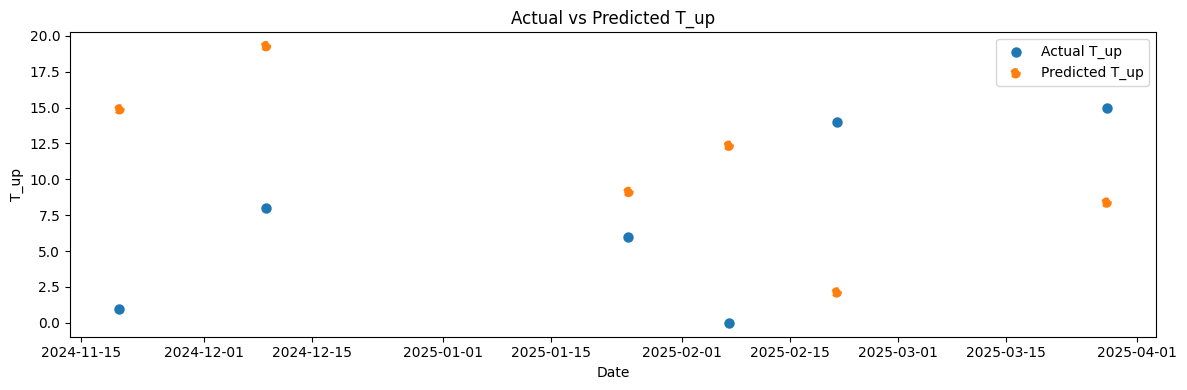

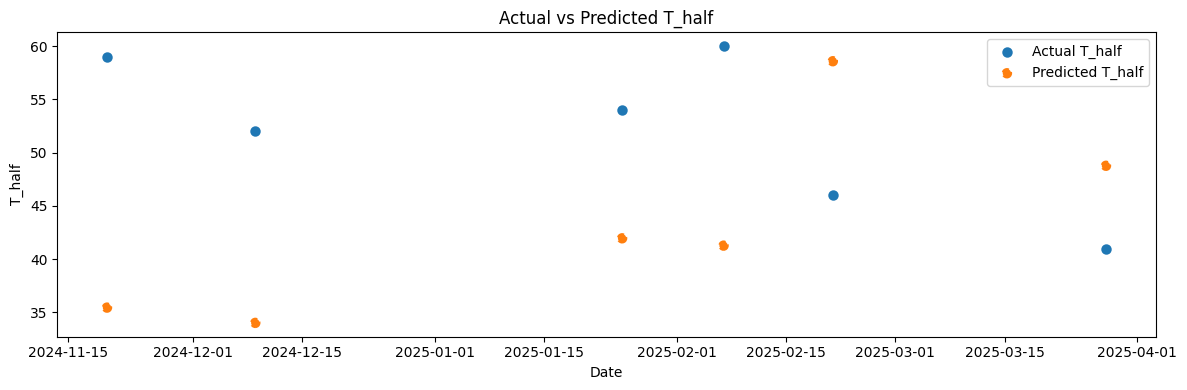

In [1518]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test       = arc_df_test[feature_cols].values
dates        = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("xgb_peak_vix_tuned.pkl"),
    "T_up":     joblib.load("xgb_T_up_tuned.pkl"),
    "T_half":   joblib.load("xgb_T_half_tuned.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# RECENT/TRADE

In [378]:
arc_df_test.head()

peak_vix       vix0  T_up  T_half  summary_mean  summary_min  \
date_start                                                                  
2024-04-14  16.940001  16.940001   1.0    54.0      -0.08967    -0.974704   
2024-08-01  38.570000  23.389999   1.0    10.0      -0.08967    -0.974704   
2024-08-30  22.639999  15.370000   9.0    25.0      -0.08967    -0.974704   
2024-09-30  23.160000  18.030001  13.0    30.0      -0.08967    -0.974704   
2024-10-02  23.160000  18.030001  13.0    32.0      -0.08967    -0.974704   

            summary_max  summary_pos_count  summary_neg_count  headline_mean  \
date_start                                                                     
2024-04-14     0.945365              109.0               50.0      -0.145494   
2024-08-01     0.945365              109.0               50.0      -0.145494   
2024-08-30     0.945365              109.0               50.0      -0.145494   
2024-09-30     0.945365              109.0               50.0      -0.145494   
2024-10-02     0.945365              109.0               50.0      -0.145494   

            ...  summary_range  headline_pos_ratio  headline_neg_ratio  \
date_start  ...                                                          
2024-04-14  ...       1.920069            0.672956            0.327044   
2024-08-01  ...       1.920069            0.672956            0.327044   
2024-08-30  ...       1.920069            0.672956            0.327044   
2024-09-30  ...       1.920069            0.672956            0.327044   
2024-10-02  ...       1.920069            0.672956            0.327044   

            headline_range  overall_pos_ratio  overall_neg_ratio  \
date_start                                                         
2024-04-14        1.918942           0.679245           0.320755   
2024-08-01        1.918942           0.679245           0.320755   
2024-08-30        1.918942           0.679245           0.320755   
2024-09-30        1.918942           0.679245           0.320755   
2024-10-02        1.918942           0.679245           0.320755   

            overall_range  dom_0  dom_1  early_spike_prob  
date_start                                                 
2024-04-14       1.919505    1.0    0.0           -1.0000  
2024-08-01       1.919505    1.0    0.0            0.7900  
2024-08-30       1.919505    1.0    0.0           -1.0000  
2024-09-30       1.919505    1.0    0.0            0.7950  
2024-10-02       1.919505    1.0    0.0            0.7425  

[5 rows x 39 columns]

In [379]:
test_df_trade

date      date.1  summary_mean  summary_min  summary_max  \
date                                                                         
2024-01-01  2024-01-01  2024-01-01      0.230589    -0.975066     0.928364   
2024-01-02  2024-01-02  2024-01-02     -0.051116    -0.972233     0.934338   
2024-01-03  2024-01-03  2024-01-03     -0.298161    -0.972755     0.943392   
2024-01-04  2024-01-04  2024-01-04     -0.376740    -0.974324     0.934698   
2024-01-05  2024-01-05  2024-01-05     -0.332922    -0.973382     0.931713   
...                ...         ...           ...          ...          ...   
2025-04-12  2025-04-12  2025-04-12     -0.089461    -0.957227     0.948515   
2025-04-13  2025-04-13  2025-04-13     -0.086733    -0.972444     0.952317   
2025-04-14  2025-04-14  2025-04-14     -0.063972    -0.972737     0.948741   
2025-04-15  2025-04-15  2025-04-15     -0.174286    -0.975042     0.950775   
2025-04-16  2025-04-16  2025-04-16     -0.254442    -0.974785     0.947952   

            summary_pos_count  summary_neg_count  headline_mean  headline_min  \
date                                                                            
2024-01-01                  3                  1       0.256950     -0.707050   
2024-01-02                 15                 10      -0.059740     -0.932877   
2024-01-03                 31                 42      -0.345787     -0.969059   
2024-01-04                 17                 34      -0.429220     -0.973915   
2024-01-05                 17                 26       0.154316     -0.970470   
...                       ...                ...            ...           ...   
2025-04-12                 90                 43      -0.008691     -0.941981   
2025-04-13                 74                 31      -0.158017     -0.968547   
2025-04-14                239                123      -0.219557     -0.973235   
2025-04-15                181                117      -0.138407     -0.974432   
2025-04-16                205                169      -0.164961     -0.974998   

            headline_max  ...  overall_pos_count  overall_neg_count  \
date                      ...                                         
2024-01-01      0.939984  ...                  6                  2   
2024-01-02      0.941353  ...                 31                 19   
2024-01-03      0.918668  ...                 60                 86   
2024-01-04      0.948764  ...                 34                 68   
2024-01-05      0.945269  ...                 49                 37   
...                  ...  ...                ...                ...   
2025-04-12      0.939109  ...                195                 71   
2025-04-13      0.952738  ...                145                 65   
2025-04-14      0.940637  ...                447                277   
2025-04-15      0.948124  ...                376                220   
2025-04-16      0.955106  ...                452                296   

            vix_target  mean_sentiment_decay  shock_pos  shock_neg  \
date                                                                 
2024-01-01   13.200000             -0.117582   0.934174  -0.841058   
2024-01-02   13.200000              0.243770   0.937845  -0.952555   
2024-01-03   14.040000             -0.055428   0.931030  -0.970907   
2024-01-04   14.130000             -0.321974   0.941731  -0.974120   
2024-01-05   13.350000             -0.402980   0.938491  -0.971926   
...                ...                   ...        ...        ...   
2025-04-12   30.889999             -0.304711   0.943812  -0.949604   
2025-04-13   30.889999             -0.049076   0.952528  -0.970495   
2025-04-14   30.889999             -0.122375   0.944689  -0.972986   
2025-04-15   30.120001             -0.141765   0.949450  -0.974737   
2025-04-16   32.639999             -0.156347   0.951529  -0.974891   

            sentiment_dominance  dominance_trigger  vix_7d_pct  vix_zscore  
date                                 

In [380]:
def get_past_60_trading_days(df, target_date):
    """
    Given a DataFrame with a DatetimeIndex and a target date (string or datetime),
    return the 60 trading days *before* that date (exclusive).
    """
    # Ensure datetime format
    target_date = pd.to_datetime(target_date)
    
    # Filter to dates strictly before the target date
    df_before = df[df.index < target_date]
    
    # Get last 60 rows before the target date
    return df_before.tail(61)


In [381]:
df_trade = get_past_60_trading_days(test_df_trade, "2024-08-03")

In [382]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data

X_test = df_trade[selected_features]
y_test = df_trade['vix_target']



# 3. Define same model on test data
model_trade = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_trade.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
df_trade['regime_t'] = results_test.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.0008 else 0)
df_trade['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
df_trade['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [383]:
df_trade.tail()

date      date.1  summary_mean  summary_min  summary_max  \
date                                                                         
2024-07-29  2024-07-29  2024-07-29     -0.024781    -0.975219     0.951208   
2024-07-30  2024-07-30  2024-07-30     -0.204579    -0.976219     0.946473   
2024-07-31  2024-07-31  2024-07-31      0.026915    -0.973044     0.951762   
2024-08-01  2024-08-01  2024-08-01     -0.292869    -0.973897     0.947609   
2024-08-02  2024-08-02  2024-08-02     -0.438248    -0.974019     0.949843   

            summary_pos_count  summary_neg_count  headline_mean  headline_min  \
date                                                                            
2024-07-29                 78                 54      -0.002707     -0.973883   
2024-07-30                 81                 66      -0.195919     -0.973511   
2024-07-31                151                107      -0.001486     -0.972432   
2024-08-01                 65                 99      -0.278619     -0.974209   
2024-08-02                 48                 91      -0.245252     -0.970599   

            headline_max  ...  mean_sentiment_decay  shock_pos  shock_neg  \
date                      ...                                               
2024-07-29      0.948594  ...             -0.202453   0.949901  -0.974551   
2024-07-30      0.955319  ...             -0.013744   0.950896  -0.974865   
2024-07-31      0.953569  ...             -0.200249   0.952666  -0.972738   
2024-08-01      0.950001  ...              0.012714   0.948805  -0.974053   
2024-08-02      0.947298  ...             -0.285744   0.948571  -0.972309   

            sentiment_dominance  dominance_trigger  vix_7d_pct  vix_zscore  \
date                                                                         
2024-07-29                   24                  0    0.265244    1.273815   
2024-07-30                   15                  0    0.348323    1.674711   
2024-07-31                   44                  0    0.240334    0.955339   
2024-08-01                  -34                  1    0.283840    1.867475   
2024-08-02                  -43                  1    0.468299    3.224119   

            regime_t  regime_t_raw  panic_prob_t+1  
date                                                
2024-07-29         0      0.000087        0.589064  
2024-07-30         0      0.000233        0.533438  
2024-07-31         0      0.000070        0.596039  
2024-08-01         0      0.000220        0.564912  
2024-08-02         1      0.014743        0.654146  

[5 rows x 28 columns]

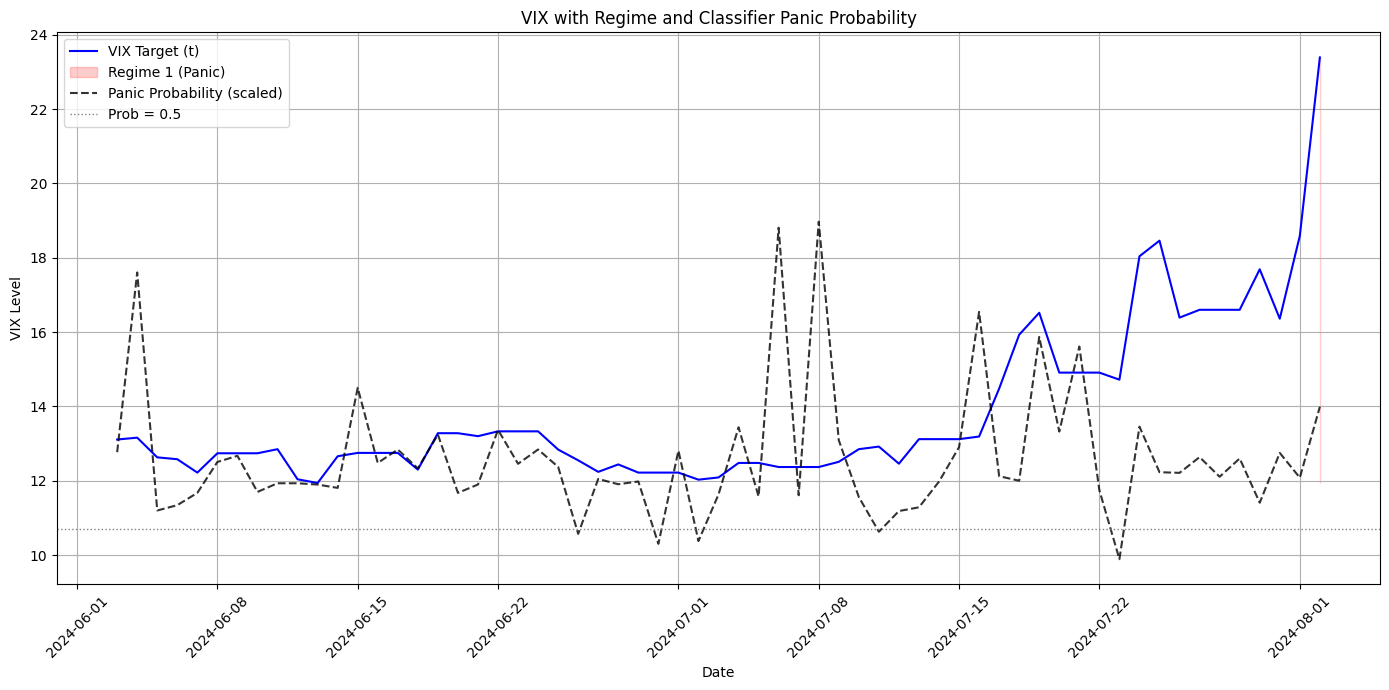

In [579]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(df_trade.index, df_trade["vix_target"], label="VIX Target (t)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    df_trade.index,
    df_trade["vix_target"].min(),
    df_trade["vix_target"].max(),
    where=df_trade["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = df_trade["panic_prob_t+1"] * (df_trade["vix_target"].max() - 2)
plt.plot(df_trade.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (df_trade["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [580]:
classification_df_trade = macro_utils.identify_sustained_regimes_and_transitions(df_trade, trade = True)

In [581]:
classification_df_trade.tail()

summary_mean  summary_min  summary_max  summary_pos_count  \
date                                                                    
2024-07-29     -0.024781    -0.975219     0.951208                 78   
2024-07-30     -0.204579    -0.976219     0.946473                 81   
2024-07-31      0.026915    -0.973044     0.951762                151   
2024-08-01     -0.292869    -0.973897     0.947609                 65   
2024-08-02     -0.438248    -0.974019     0.949843                 48   

            summary_neg_count  headline_mean  headline_min  headline_max  \
date                                                                       
2024-07-29                 54      -0.002707     -0.973883      0.948594   
2024-07-30                 66      -0.195919     -0.973511      0.955319   
2024-07-31                107      -0.001486     -0.972432      0.953569   
2024-08-01                 99      -0.278619     -0.974209      0.950001   
2024-08-02                 91      -0.245252     -0.970599      0.947298   

            headline_pos_count  headline_neg_count  ...  dominance_trigger  \
date                                                ...                      
2024-07-29                  94                  38  ...                  0   
2024-07-30                  82                  65  ...                  0   
2024-07-31                 165                  93  ...                  0   
2024-08-01                  75                  89  ...                  1   
2024-08-02                  65                  74  ...                  1   

            vix_7d_pct  vix_zscore  regime_t  regime_t_raw  panic_prob_t+1  \
date                                                                         
2024-07-29    0.265244    1.273815         0      0.000087        0.589064   
2024-07-30    0.348323    1.674711         0      0.000233        0.533438   
2024-07-31    0.240334    0.955339         0      0.000070        0.596039   
2024-08-01    0.283840    1.867475         0      0.000220        0.564912   
2024-08-02    0.468299    3.224119         1      0.014743        0.654146   

            regime_group  is_sustained_regime1  regime_t-1  is_transition  
date                                                                       
2024-07-29             1                 False         0.0          False  
2024-07-30             1                 False         0.0          False  
2024-07-31             1                 False         0.0          False  
2024-08-01             1                 False         0.0          False  
2024-08-02             2                  True         0.0           True  

[5 rows x 30 columns]

In [582]:
result_trade = macro_utils.transform_vix_data(classification_df_trade, window=60, trade = True)
vix_windows_past_df_trade = result_trade["vix_windows_past_df_train"]

In [583]:
classification_df_trade = classification_df_trade.drop(columns=['date', 'date.1'], axis=1)

KeyError: "['date', 'date.1'] not found in axis"

In [584]:
df_trade = df_trade.drop(columns=['date', 'date.1'], axis=1)

KeyError: "['date', 'date.1'] not found in axis"

In [585]:
from macro_utils import calculate_pct_changes

# Get current date (your live transition point — usually last row in trade DF)
live_index = classification_df_trade[classification_df_trade["is_transition"]].index[-1:]
print(f"✅ Using live index: {live_index}")

# Calculate past % changes from historical VIX column
vix_pct_change_lookback_df_trade, used_indices = calculate_pct_changes(
    df_model=classification_df_trade,
    valid_indices=live_index,
    lookback=30,
    vix_column="vix_target"
)

# Now predict with  classifier
early_spike_prob_trade = clf_delayed_spike_prob.predict_proba(vix_pct_change_lookback_df_trade)[0][1]
print(f"🟢 Early spike probability: {early_spike_prob_trade:.2%}")


✅ Using live index: DatetimeIndex(['2024-08-02'], dtype='datetime64[ns]', name='date', freq=None)
🟢 Early spike probability: 84.25%


In [586]:
vix_pct_change_lookback_df_trade.head()

Day -30   Day -29  Day -28   Day -27  Day -26  Day -25   Day -24  \
2024-08-02  0.004988  0.032258      0.0 -0.008814      0.0      0.0  0.011318   

             Day -23   Day -22   Day -21  ...   Day -10    Day -9    Day -8  \
2024-08-02  0.027178  0.005447 -0.035604  ... -0.012743  0.225544  0.023281   

              Day -7    Day -6  Day -5  Day -4    Day -3    Day -2    Day -1  
2024-08-02 -0.112134  0.012813     0.0     0.0  0.065663 -0.075184  0.136308  

[1 rows x 30 columns]

In [587]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = df_trade.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        pos = f'{prefix}_pos_count'
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

        out[tot] = out[[pos, neg]].sum(axis=1).replace(0, 1)      # avoid ÷0
        out[f'{prefix}_pos_ratio'] = out[pos] / out[tot]
        out[f'{prefix}_neg_ratio'] = out[neg] / out[tot]
        out[f'{prefix}_range']     = out[f'{prefix}_max'] - out[f'{prefix}_min']

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_trade = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_trade.index = pd.to_datetime(news_feats_trade.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_trade.index.min(),
                          news_feats_trade.index.max(),
                          freq='D')

news_dense_trade = (
    news_feats_trade
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



In [588]:
news_dense_trade.columns

Index(['summary_mean', 'summary_min', 'summary_max', 'summary_pos_count',
       'summary_neg_count', 'headline_mean', 'headline_min', 'headline_max',
       'headline_pos_count', 'headline_neg_count', 'overall_mean',
       'overall_min', 'overall_max', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_pos', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'regime_t', 'regime_t_raw', 'panic_prob_t+1', 'regime_group',
       'is_sustained_regime1', 'regime_t-1', 'is_transition',
       'summary_pos_ratio', 'summary_neg_ratio', 'summary_range',
       'headline_pos_ratio', 'headline_neg_ratio', 'headline_range',
       'overall_pos_ratio', 'overall_neg_ratio', 'overall_range', 'dom_0',
       'dom_1'],
      dtype='object')

In [589]:
feature_cols = feature_cols.drop(['date','date.1'], errors='ignore')


In [590]:
df_trade.columns

Index(['summary_mean', 'summary_min', 'summary_max', 'summary_pos_count',
       'summary_neg_count', 'headline_mean', 'headline_min', 'headline_max',
       'headline_pos_count', 'headline_neg_count', 'overall_mean',
       'overall_min', 'overall_max', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_pos', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'regime_t', 'regime_t_raw', 'panic_prob_t+1', 'regime_group',
       'is_sustained_regime1', 'regime_t-1', 'is_transition'],
      dtype='object')

In [591]:
def build_live_arc_row(start_idx, news_dense, classification_df_trade, feature_cols):
    row = classification_df_trade.loc[[start_idx]].copy()

    # 1. News features (safe drop of 'date' if it exists)
    dt_norm = pd.to_datetime(start_idx).normalize()
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].drop(labels=["date"], errors="ignore").to_dict()
    except IndexError:
        print("❌ No prior news available.")
        return None

    # 2. One-hot encode dominance
    dom_dummies = pd.get_dummies(row['dominance_trigger'], prefix='dom')
    for col in ['dom_0', 'dom_1']:
        if col not in dom_dummies.columns:
            dom_dummies[col] = 0
    row = pd.concat([row, dom_dummies], axis=1)

    # 3. Merge in engineered news features
    row = row.assign(**feats_on_start)

    # 4. Drop any raw metadata columns you don't want leaking in
    row = row.drop(columns=[c for c in row.columns if c.startswith("date")], errors="ignore")

    # 5. Safely extract just the needed feature values
    feature_values = {
        col: row[col].values[0] if col in row.columns else 0
        for col in feature_cols
    }

    # 6. Return final row with only feature_cols — guarantees alignment
    arc_row = pd.DataFrame([feature_values], index=[start_idx])[feature_cols]
    return arc_row


In [592]:
start_idx = classification_df_trade[classification_df_trade["is_transition"]].index[-1]

# Build feature row
arc_row_live = build_live_arc_row(start_idx, news_dense_trade, classification_df_trade, feature_cols)


In [593]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [594]:
print(early_spike_prob_trade)

0.8425


In [595]:
if early_spike_prob_trade > 0.75:
    min_vix=df_trade['vix_target'].iloc[-20:].min()
    arc_row_live['vix0'] = min_vix
    print('<')
    print(min_vix)
else:
    min_vix=df_trade['vix_target'].iloc[-10:].min()
    arc_row_live['vix0'] = min_vix
    print(min_vix)


<
13.119999885559082


In [596]:
print(arc_row_live['vix0'])

2024-08-02    13.12
Name: vix0, dtype: float64


In [598]:
arc_row_live.columns

Index(['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob',
       'headline_max', 'headline_mean', 'headline_min', 'headline_neg_count',
       'headline_neg_ratio', 'headline_pos_count', 'headline_pos_ratio',
       'headline_range', 'mean_sentiment_decay', 'overall_max', 'overall_mean',
       'overall_min', 'overall_neg_count', 'overall_neg_ratio',
       'overall_pos_count', 'overall_pos_ratio', 'overall_range',
       'sentiment_dominance', 'shock_neg', 'shock_pos', 'summary_max',
       'summary_mean', 'summary_min', 'summary_neg_count', 'summary_neg_ratio',
       'summary_pos_count', 'summary_pos_ratio', 'summary_range', 'vix0',
       'vix_7d_pct', 'vix_target', 'vix_zscore'],
      dtype='object')

In [599]:
import joblib
import pandas as pd

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}


In [600]:
arc_row_live['vix0']

2024-08-02    13.12
Name: vix0, dtype: float64

In [601]:

# Predict
if arc_row_live is not None:
    live_preds = {
        target: float(models[target].predict(arc_row_live[feature_cols].values))
        for target in models
    }

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<8} → {val:.2f}")
else:
    print("❌ Failed to build input row.")


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(models[target].predict(arc_row_live[feature_cols].values))



📍 Live prediction at 2024-08-02:
  peak_vix → 25.40
  T_up     → 17.63
  T_half   → 29.32


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(models[target].predict(arc_row_live[feature_cols].values))


# XGB prediction

In [1323]:
import joblib
import pandas as pd

xgb_models = {
    "peak_vix": joblib.load("xgb_peak_vix_tuned.pkl"),
    "T_up":     joblib.load("xgb_T_up_tuned.pkl"),
    "T_half":   joblib.load("xgb_T_half_tuned.pkl"),
}


In [1324]:

# Predict
if arc_row_live is not None:
    live_preds = {
        target: float(xgb_models[target].predict(arc_row_live[feature_cols].values))
        for target in xgb_models
    }

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<8} → {val:.2f}")
else:
    print("❌ Failed to build input row.")


KeyError: "['ewm_mean', 'ewm_std', 'vix_ewm_zscore'] not in index"